In [2]:
%matplotlib ipympl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from sklearn.metrics import pairwise_distances# Load your DataFrame (result_df) if you haven't already


import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy import stats


import numpy as np
import tensorflow as tf
import keras

import os
cwd = os.getcwd()

2024-08-21 03:08:17.607777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 03:08:17.744674: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 03:08:17.750269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/10.2.0/lib:/cm/local/apps/gcc/10.2.0/lib64:/cm/local/apps/gcc/10.2.0/lib32:/c

# Get start and end time for difficulty

In [77]:
df_ts = pd.read_pickle('df_task_switch.pkl')
temp_df = df_ts['data'].apply(lambda x: pd.Series(x))
df_ts = pd.concat([df_ts.drop('data', axis=1), temp_df], axis=1)
df_ts['Task_type'] = 'task_switching'
df_ts = df_ts[['userid','Task_type','Difficulty','Start_time','End_time']]
df_ts = df_ts.explode(['Difficulty','Start_time','End_time'])
df_ts

userid       Task_type Difficulty     Start_time         End_time
0    BVCX  task_switching       Hard  1710354158650  1710354159530.0
0    BVCX  task_switching       Hard  1710354160210             None
0    BVCX  task_switching       Hard  1710354161890             None
0    BVCX  task_switching       Hard  1710354163570  1710354164510.0
0    BVCX  task_switching       Hard  1710354165190  1710354165770.0
..    ...             ...        ...            ...              ...
99   YTRE  task_switching       Hard  1711639475175  1711639475854.0
99   YTRE  task_switching       Hard  1711639476534             None
99   YTRE  task_switching       Hard  1711639478214  1711639479115.0
99   YTRE  task_switching       Hard  1711639479794  1711639480495.0
99   YTRE  task_switching       Hard  1711639481175  1711639481975.0

[24300 rows x 5 columns]

In [3]:
df_enum = pd.read_pickle('df_enumeration.pkl')
temp_df = df_enum['data'].apply(lambda x: pd.Series(x))
df_enum = pd.concat([df_enum.drop('data', axis=1), temp_df], axis=1)
df_enum['Task_type'] = 'enumeration'
df_enum = df_enum[['userid','Task_type','Difficulty','Start_time','End_time']]
df_enum = df_enum.explode(['Difficulty','Start_time','End_time'])
df_enum

userid    Task_type Difficulty     Start_time       End_time
0    BVCX  enumeration       Easy  1710354640593  1710354642601
0    BVCX  enumeration       Easy  1710354645123  1710354646364
0    BVCX  enumeration       Easy  1710354648903  1710354650563
0    BVCX  enumeration       Easy  1710354653083  1710354654330
0    BVCX  enumeration       Easy  1710354656863  1710354658291
..    ...          ...        ...            ...            ...
99   YTRE  enumeration       Easy  1711638720953  1711638723555
99   YTRE  enumeration       Easy  1711638726093  1711638728111
99   YTRE  enumeration       Easy  1711638730633  1711638736801
99   YTRE  enumeration       Easy  1711638739352  1711638741752
99   YTRE  enumeration       Easy  1711638744293  1711638746001

[6000 rows x 5 columns]

In [4]:
df_wm = pd.read_pickle('df_working_memory.pkl')
temp_df = df_wm['data'].apply(lambda x: pd.Series(x))
df_wm = pd.concat([df_wm.drop('data', axis=1), temp_df], axis=1)
df_wm['Task_type'] = 'working_memory'
df_wm = df_wm[['userid','Task_type','Difficulty','Start_time','End_time']]
df_wm = df_wm.explode(['Difficulty','Start_time','End_time'])
df_wm

userid       Task_type Difficulty     Start_time       End_time
0    BVCX  working_memory       Easy  1710353214025  1710353216085
0    BVCX  working_memory       Easy  1710353222205  1710353224405
0    BVCX  working_memory       Easy  1710353229325  1710353231425
0    BVCX  working_memory       Easy  1710353237545  1710353240265
0    BVCX  working_memory       Easy  1710353245185  1710353247165
..    ...             ...        ...            ...            ...
96   YTRE  working_memory     Medium  1711640455003  1711640459063
96   YTRE  working_memory     Medium  1711640467583  1711640470003
96   YTRE  working_memory     Medium  1711640477323  1711640479483
96   YTRE  working_memory     Medium  1711640488023  1711640490643
96   YTRE  working_memory     Medium  1711640499163  1711640501663

[5820 rows x 5 columns]

In [5]:
df_merge = pd.concat([df_enum,df_ts,df_wm])
df_merge = df_merge.replace('None', np.nan)
df_merge

userid       Task_type Difficulty     Start_time      End_time
0    BVCX     enumeration       Easy  1710354640593  1.710355e+12
0    BVCX     enumeration       Easy  1710354645123  1.710355e+12
0    BVCX     enumeration       Easy  1710354648903  1.710355e+12
0    BVCX     enumeration       Easy  1710354653083  1.710355e+12
0    BVCX     enumeration       Easy  1710354656863  1.710355e+12
..    ...             ...        ...            ...           ...
96   YTRE  working_memory     Medium  1711640455003  1.711640e+12
96   YTRE  working_memory     Medium  1711640467583  1.711640e+12
96   YTRE  working_memory     Medium  1711640477323  1.711640e+12
96   YTRE  working_memory     Medium  1711640488023  1.711640e+12
96   YTRE  working_memory     Medium  1711640499163  1.711641e+12

[36120 rows x 5 columns]

In [6]:
USERID_LIST = df_merge['userid'].unique()
USERID_LIST

array(['BVCX', 'CVBN', 'DKLQ', 'EDFR', 'FDSA', 'FGHZ', 'HGFD', 'JHGF',
       'JKLZ', 'MYTZ', 'NMBV', 'NMKL', 'PKJH', 'PLMO', 'QPMN', 'QWER',
       'QWRT', 'QXZW', 'SBQRG', 'SJWQP', 'SVTZM', 'SXVBN', 'TGVB', 'TYDF',
       'WERT', 'WZXE', 'XZPT', 'YUZW', 'ZXAS', 'ZXWE', 'ZYXW', 'BHGY',
       'HJKL', 'JFDE', 'JKLM', 'KJHG', 'LKJH', 'LPDW', 'MJKL', 'MJUY',
       'NBVC', 'NVBX', 'QAXY', 'QPLM', 'REWQ', 'RIQW', 'RTGH', 'SBTBT',
       'SNMVN', 'TYZX', 'UIOP', 'UYGH', 'VIWZ', 'VNPL', 'XCVH', 'XRTY',
       'ZRTY', 'ZXCJ', 'ZXCV', 'ZXNM', 'FTLD', 'FYDR', 'GHJK', 'GTYU',
       'HPLX', 'JKZX', 'LKMN', 'LKPW', 'LPZV', 'NHZA', 'NMJU', 'POIU',
       'STWXJ', 'UJNH', 'UPLK', 'UYTR', 'VBNM', 'XCVN', 'AXSW', 'DFGH',
       'DFZX', 'FDXC', 'FTYP', 'GHFJ', 'LRTB', 'MNBW', 'MNOP', 'MTYH',
       'OPKJ', 'PLRQ', 'QAZW', 'QPOI', 'RQWE', 'SHYXZ', 'SLMJK', 'SPKZR',
       'SRKLP', 'VFTY', 'XUYP', 'YTRE'], dtype=object)

In [7]:
TASK_LIST = df_merge['Task_type'].unique()
TASK_LIST

array(['enumeration', 'task_switching', 'working_memory'], dtype=object)

In [8]:
DIFF_LIST = df_merge['Difficulty'].unique()
DIFF_LIST

array(['Easy', 'Medium', 'Hard'], dtype=object)

In [9]:
df_merge_groups = df_merge.groupby(['userid', 'Task_type', 'Difficulty'])

# Loop through each group and print the shape
for (current_id,current_task,current_diff), df_merge_group in df_merge_groups:
    print(f"userID: {current_id}, Task: {current_task}, Difficulty: {current_diff}, Shape: {df_merge_group.shape}")
    start_time = df_merge_group['Start_time'].min()
    end_time = df_merge_group['End_time'].max()

userID: AXSW, Task: enumeration, Difficulty: Easy, Shape: (20, 5)
userID: AXSW, Task: enumeration, Difficulty: Hard, Shape: (20, 5)
userID: AXSW, Task: enumeration, Difficulty: Medium, Shape: (20, 5)
userID: AXSW, Task: task_switching, Difficulty: Easy, Shape: (81, 5)
userID: AXSW, Task: task_switching, Difficulty: Hard, Shape: (81, 5)
userID: AXSW, Task: task_switching, Difficulty: Medium, Shape: (81, 5)
userID: AXSW, Task: working_memory, Difficulty: Easy, Shape: (20, 5)
userID: AXSW, Task: working_memory, Difficulty: Hard, Shape: (20, 5)
userID: AXSW, Task: working_memory, Difficulty: Medium, Shape: (20, 5)
userID: BHGY, Task: enumeration, Difficulty: Easy, Shape: (20, 5)
userID: BHGY, Task: enumeration, Difficulty: Hard, Shape: (20, 5)
userID: BHGY, Task: enumeration, Difficulty: Medium, Shape: (20, 5)
userID: BHGY, Task: task_switching, Difficulty: Easy, Shape: (81, 5)
userID: BHGY, Task: task_switching, Difficulty: Hard, Shape: (81, 5)
userID: BHGY, Task: task_switching, Difficul

In [10]:
df_merge_group['Start_time'].min()

1706216435099

In [11]:
df_merge_group['End_time'].max()

1706216639115.0

# Eye Tracking

In [2]:
eye_model = tf.keras.models.load_model('quang_model_old')
eye_model.summary()
eye_model.predict(np.random.rand(1,250,3))

2024-08-17 01:24:23.198232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/10.2.0/lib:/cm/local/apps/gcc/10.2.0/lib64:/cm/local/apps/gcc/10.2.0/lib32:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-08-17 01:24:23.198371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/10.2.0/lib:/cm/local/apps/gcc/10.2.0/lib64:/cm/local/apps/gcc/10.2.0/lib32:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-08-17 01:24:23.198460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 125, 64)      1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 42, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 42, 64)       0           ['max_pooling1d[0][0]']          
                                                                                              

[array([[0.11731842]], dtype=float32),
 array([[0.55237234, 0.5536542 , 0.556599  , 0.55846995, 0.5605853 ,
         0.56349707, 0.5647924 , 0.5670836 , 0.56907856, 0.5714385 ,
         0.573248  , 0.57531595, 0.57835233, 0.58089215, 0.5829462 ,
         0.58512783, 0.5868927 , 0.5891421 , 0.590902  , 0.59304786,
         0.59429413, 0.59599835, 0.59752905, 0.5982166 , 0.60001695,
         0.60160285, 0.6033186 , 0.60496235, 0.60602343, 0.6074439 ,
         0.6094289 , 0.6106528 , 0.61214155, 0.61342454, 0.6147482 ,
         0.61614203, 0.61790025, 0.61948514, 0.62108856, 0.6234482 ,
         0.6246797 , 0.6259214 , 0.6272768 , 0.6299628 , 0.6303543 ,
         0.6321832 , 0.6337188 , 0.63500905, 0.6358774 , 0.63737226,
         0.6385835 , 0.6399026 , 0.641702  , 0.64233   , 0.64337325,
         0.6451339 , 0.64600956, 0.64750665, 0.6483414 , 0.64915013,
         0.6507414 , 0.651363  , 0.6530444 , 0.6539929 , 0.65386456,
         0.6544733 , 0.6558194 , 0.6575001 , 0.6588626 , 0.66046

In [3]:
df_eye = pd.read_pickle("df_eye.pkl")
#df_eye = df_eye[df_eye['game_type'] != 'baseline']
df_eye

subject_id                                           eye_data  \
0         BVCX  {'Timestamp': [1710352642777.923, 171035264276...   
1         BVCX  {'Timestamp': [1710354603794.525, 171035460381...   
2         BVCX  {'Timestamp': [1710354023688.477, 171035402375...   
3         BVCX  {'Timestamp': [1710353127527.266, 171035312754...   
4         CVBN  {'Timestamp': [1710444817133.011, 171044481714...   
..         ...                                                ...   
395       YTRE  {'Timestamp': [1711637695846.3, 1711637695859....   
396       YTRE  {'Timestamp': [1711638199400.047, 171163819942...   
397       YTRE  {'Timestamp': [1711638876414.245, 171163887643...   
398       YTRE  {'Timestamp': [1711639643643.328, 171163964365...   
399       GHFJ  {'Timestamp': [1709837487709.906, 170983748772...   

          game_type  
0          baseline  
1       enumeration  
2    task_switching  
3    working_memory  
4          baseline  
..              ...  
395        baseline  
396     enumeration  
397  task_switching  
398  working_memory  
399        baseline  

[400 rows x 3 columns]

In [4]:
eye_grouped = df_eye.groupby('subject_id')

In [5]:

def calculate_pupil_average(row):
    if pd.isna(row['Pupil_left']) and pd.isna(row['Pupil_right']):
        return np.nan
    elif pd.isna(row['Pupil_left']):
        return row['Pupil_right']
    elif pd.isna(row['Pupil_right']):
        return row['Pupil_left']
    else:
        return (row['Pupil_left'] + row['Pupil_right']) / 2

In [6]:
FEATURES_LIST = ['PD','Gaze_X','Gaze_Y']

# data is pandas.DataFrame
# ml_model should have predict method
def online_prediction(data,ml_model,begin = 0, predict_interval = 25, features = FEATURES_LIST):
    samples_list = []
    online_predict = []
    end = begin + 250
    scaler = StandardScaler()
    data[FEATURES_LIST] = scaler.fit_transform(data[FEATURES_LIST])
    #generate samples
    while begin < (len(data) - 250):
        temp_sample = np.array(data.iloc[begin:end][features])
        
        
        #filter nan
        if np.isnan(temp_sample).sum() > 0:
            begin += predict_interval 
            end = begin + 250
            continue
            
        samples_list.append(temp_sample)
        
        begin += predict_interval 
        end = begin + 250
    
    
    # predicting
    samples_list = np.array(samples_list)    
    if len(samples_list) == 0:
        return samples_list
        
    online_predict, _ = ml_model.predict(samples_list)
    return online_predict

In [7]:
for subject_id, group in eye_grouped:
    print(f"Subject ID: {subject_id}, Shape: {group.shape}")

Subject ID: AXSW, Shape: (4, 3)
Subject ID: BHGY, Shape: (4, 3)
Subject ID: BVCX, Shape: (4, 3)
Subject ID: CVBN, Shape: (4, 3)
Subject ID: DFGH, Shape: (4, 3)
Subject ID: DFZX, Shape: (4, 3)
Subject ID: DKLQ, Shape: (4, 3)
Subject ID: EDFR, Shape: (4, 3)
Subject ID: FDSA, Shape: (4, 3)
Subject ID: FDXC, Shape: (4, 3)
Subject ID: FGHZ, Shape: (4, 3)
Subject ID: FTLD, Shape: (4, 3)
Subject ID: FTYP, Shape: (4, 3)
Subject ID: FYDR, Shape: (4, 3)
Subject ID: GHFJ, Shape: (4, 3)
Subject ID: GHJK, Shape: (4, 3)
Subject ID: GTYU, Shape: (4, 3)
Subject ID: HGFD, Shape: (4, 3)
Subject ID: HJKL, Shape: (4, 3)
Subject ID: HPLX, Shape: (4, 3)
Subject ID: JFDE, Shape: (4, 3)
Subject ID: JHGF, Shape: (4, 3)
Subject ID: JKLM, Shape: (4, 3)
Subject ID: JKLZ, Shape: (4, 3)
Subject ID: JKZX, Shape: (4, 3)
Subject ID: KJHG, Shape: (4, 3)
Subject ID: LKJH, Shape: (4, 3)
Subject ID: LKMN, Shape: (4, 3)
Subject ID: LKPW, Shape: (4, 3)
Subject ID: LPDW, Shape: (4, 3)
Subject ID: LPZV, Shape: (4, 3)
Subject 

In [8]:
group

subject_id                                           eye_data  \
120       ZYXW  {'Timestamp': [1706214859009.634, 170621485902...   
121       ZYXW  {'Timestamp': [1706216758408.362, 170621675842...   
122       ZYXW  {'Timestamp': [1706215236454.986, 170621523646...   
123       ZYXW  {'Timestamp': [1706215837319.193, 170621583733...   

          game_type  
120        baseline  
121     enumeration  
122  task_switching  
123  working_memory

In [9]:
temp_df = group['eye_data'].apply(lambda x: pd.Series(x))
group = pd.concat([group.drop('eye_data', axis=1), temp_df], axis=1)
group

subject_id       game_type  \
120       ZYXW        baseline   
121       ZYXW     enumeration   
122       ZYXW  task_switching   
123       ZYXW  working_memory   

                                             Timestamp  \
120  [1706214859009.634, 1706214859020.123, 1706214...   
121  [1706216758408.362, 1706216758420.101, 1706216...   
122  [1706215236454.986, 1706215236465.004, 1706215...   
123  [1706215837319.193, 1706215837330.002, 1706215...   

                                                Gaze_X  \
120  [None, 0.4786160588264465, 0.4666398465633392,...   
121  [None, 0.2217143476009369, 0.1955220252275467,...   
122  [None, 0.2581740319728851, 0.2161063402891159,...   
123  [None, 0.2267167270183563, 0.1872516721487045,...   

                                                Gaze_Y  \
120  [None, 0.4529979526996612, 0.387664645910263, ...   
121  [None, 0.4464245736598968, 0.4083127975463867,...   
122  [None, 0.5923336744308472, 0.5264340043067932,...   
123  [None, 0.6050130724906921, 0.5460744500160217,...   

                                            Pupil_left  \
120  [None, 2.54278564453125, 2.6992340087890625, 3...   
121  [None, 3.2794952392578125, 3.3529052734375, 3....   
122  [None, 2.423553466796875, 2.5592193603515625, ...   
123  [None, 2.420684814453125, 2.462493896484375, 3...   

                                           Pupil_right  
120  [None, 2.65594482421875, 2.7457275390625, 3.39...  
121  [None, 3.411117553710937, 3.5069732666015625, ...  
122  [None, 2.399688720703125, 2.5442047119140625, ...  
123  [None, 2.577392578125, 2.5423583984375, 3.5651...

In [10]:
temp_3_task_df = group[group['game_type'] != 'baseline'].explode(['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right'])
temp_3_task_df = temp_3_task_df.replace('None', np.nan)

#interpolation
temp_df = temp_3_task_df[['Timestamp','Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']]
temp_df = temp_df.set_index(pd.to_datetime(temp_df['Timestamp'], unit='ms'))
temp_df = temp_df.interpolate(method='time',limit = 10)
temp_3_task_df[['Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']] = np.array(temp_df[['Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']])

temp_3_task_df['PD'] = temp_3_task_df.apply(calculate_pupil_average, axis=1)
temp_3_task_df

subject_id       game_type     Timestamp    Gaze_X    Gaze_Y  Pupil_left  \
121       ZYXW     enumeration  1.706217e+12       NaN       NaN         NaN   
121       ZYXW     enumeration  1.706217e+12  0.221714  0.446425    3.279495   
121       ZYXW     enumeration  1.706217e+12  0.195522  0.408313    3.352905   
121       ZYXW     enumeration  1.706217e+12  0.139335  0.244702    3.764801   
121       ZYXW     enumeration  1.706217e+12  0.138382  0.246726    3.758820   
..         ...             ...           ...       ...       ...         ...   
123       ZYXW  working_memory  1.706217e+12       NaN       NaN         NaN   
123       ZYXW  working_memory  1.706217e+12  0.179301  0.511600    3.133255   
123       ZYXW  working_memory  1.706217e+12  0.200208  0.505946    3.175964   
123       ZYXW  working_memory  1.706217e+12  0.206278  0.510740    3.186539   
123       ZYXW  working_memory  1.706217e+12  0.211834  0.512044    3.223846   

     Pupil_right        PD  
121          NaN       NaN  
121     3.411118  3.345306  
121     3.506973  3.429939  
121     3.916885  3.840843  
121     3.933945  3.846382  
..           ...       ...  
123     2.826092  2.826092  
123     3.345016  3.239136  
123     3.429855  3.302910  
123     3.423676  3.305107  
123     3.426880  3.325363  

[114884 rows x 8 columns]

In [11]:
temp_3_task_df

subject_id       game_type     Timestamp    Gaze_X    Gaze_Y  Pupil_left  \
121       ZYXW     enumeration  1.706217e+12       NaN       NaN         NaN   
121       ZYXW     enumeration  1.706217e+12  0.221714  0.446425    3.279495   
121       ZYXW     enumeration  1.706217e+12  0.195522  0.408313    3.352905   
121       ZYXW     enumeration  1.706217e+12  0.139335  0.244702    3.764801   
121       ZYXW     enumeration  1.706217e+12  0.138382  0.246726    3.758820   
..         ...             ...           ...       ...       ...         ...   
123       ZYXW  working_memory  1.706217e+12       NaN       NaN         NaN   
123       ZYXW  working_memory  1.706217e+12  0.179301  0.511600    3.133255   
123       ZYXW  working_memory  1.706217e+12  0.200208  0.505946    3.175964   
123       ZYXW  working_memory  1.706217e+12  0.206278  0.510740    3.186539   
123       ZYXW  working_memory  1.706217e+12  0.211834  0.512044    3.223846   

     Pupil_right        PD  
121          NaN       NaN  
121     3.411118  3.345306  
121     3.506973  3.429939  
121     3.916885  3.840843  
121     3.933945  3.846382  
..           ...       ...  
123     2.826092  2.826092  
123     3.345016  3.239136  
123     3.429855  3.302910  
123     3.423676  3.305107  
123     3.426880  3.325363  

[114884 rows x 8 columns]

In [12]:
scaler = StandardScaler()
temp_3_task_df[['PD', 'Gaze_X', 'Gaze_Y','Pupil_left','Pupil_right']] = scaler.fit_transform(temp_3_task_df[['PD', 'Gaze_X', 'Gaze_Y','Pupil_left','Pupil_right']])

In [13]:
tasks_predict = online_prediction(temp_3_task_df,eye_model,begin = 1)
print(tasks_predict.shape)

120/120 [==============================] - 0s 3ms/step
(3840, 1)


In [24]:
eye_prob = []
eye_id = []
eye_task =[]
eye_diff = []
# Loop through each group and print the shape
for (current_id,current_task,current_diff), df_merge_group in df_merge_groups:
    
    start_time = df_merge_group['Start_time'].min()
    end_time = df_merge_group['End_time'].max()
    mask = (df_eye['subject_id'] == current_id) & (df_eye['game_type'] == current_task)

    #current_df
    current_df = df_eye[mask]
    temp_df = current_df['eye_data'].apply(lambda x: pd.Series(x))
    current_df = pd.concat([current_df.drop('eye_data', axis=1), temp_df], axis=1)
    current_df = current_df.explode(['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right'])
    current_df = current_df.replace('None', np.nan)
    current_df = current_df.query('Timestamp >= @start_time and Timestamp <= @end_time')
    print(f"userID: {current_id}, Task: {current_task}, Difficulty: {current_diff}, Shape: {current_df.shape}")
    if current_df.shape[0] == 0:
        continue
        
    #interpolation
    temp_df = current_df[['Timestamp','Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']]
    temp_df = temp_df.set_index(pd.to_datetime(temp_df['Timestamp'], unit='ms'))
    temp_df = temp_df.interpolate(method='time',limit = 10)
    current_df[['Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']] = np.array(temp_df[['Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']])
    #done interpolate
    current_df['PD'] = current_df.apply(calculate_pupil_average, axis=1)

    tasks_predict = online_prediction(current_df,eye_model,begin = 1)
    print(len(tasks_predict))
    if len(tasks_predict) <= 40:
        continue

    
    eye_prob.append(np.mean(tasks_predict))
    eye_id.append(current_id)
    eye_task.append(current_task)
    eye_diff.append(current_diff)
    

userID: AXSW, Task: enumeration, Difficulty: Easy, Shape: (5725, 7)
7/7 [==============================] - 0s 4ms/step
199
userID: AXSW, Task: enumeration, Difficulty: Hard, Shape: (6237, 7)
7/7 [==============================] - 0s 4ms/step
205
userID: AXSW, Task: enumeration, Difficulty: Medium, Shape: (6228, 7)
7/7 [==============================] - 0s 4ms/step
203
userID: AXSW, Task: task_switching, Difficulty: Easy, Shape: (7848, 7)
9/9 [==============================] - 0s 3ms/step
257
userID: AXSW, Task: task_switching, Difficulty: Hard, Shape: (6566, 7)
7/7 [==============================] - 0s 4ms/step
212
userID: AXSW, Task: task_switching, Difficulty: Medium, Shape: (7788, 7)
9/9 [==============================] - 0s 3ms/step
262
userID: AXSW, Task: working_memory, Difficulty: Easy, Shape: (8568, 7)
10/10 [==============================] - 0s 4ms/step
313
userID: AXSW, Task: working_memory, Difficulty: Hard, Shape: (20504, 7)
24/24 [==============================] - 0s 3ms/s

In [16]:
for subject_id, group in eye_grouped:
    print(f"Subject ID: {subject_id}, Shape: {group.shape}")
    temp_df = group['eye_data'].apply(lambda x: pd.Series(x))
    group = pd.concat([group.drop('eye_data', axis=1), temp_df], axis=1)

    temp_baseline_df = group[group['game_type'] == 'baseline'].explode(['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right'])
    temp_baseline_df = temp_baseline_df.replace('None', np.nan)
    #interpolation
    temp_df = temp_baseline_df[['Timestamp','Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']]
    temp_df = temp_df.set_index(pd.to_datetime(temp_df['Timestamp'], unit='ms'))
    temp_df = temp_df.interpolate(method='time',limit = 10)
    temp_baseline_df[['Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']] = np.array(temp_df[['Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']])
    #done interpolate
    temp_baseline_df['PD'] = temp_baseline_df.apply(calculate_pupil_average, axis=1)

    
#     temp_3_task_df = group[group['game_type'] != 'baseline'].explode(['Timestamp','Gaze_X','Gaze_Y','Pupil_left','Pupil_right'])
#     temp_3_task_df = temp_3_task_df.replace('None', np.nan)
#     #interpolation
#     temp_df = temp_3_task_df[['Timestamp','Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']]
#     temp_df = temp_df.set_index(pd.to_datetime(temp_df['Timestamp'], unit='ms'))
#     temp_df = temp_df.interpolate(method='time',limit = 10)
#     temp_3_task_df[['Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']] = np.array(temp_df[['Gaze_X', 'Gaze_Y', 'Pupil_left', 'Pupil_right']])
#     #done interpolate
#     temp_3_task_df['PD'] = temp_3_task_df.apply(calculate_pupil_average, axis=1)
    
    baseline_predict = online_prediction(temp_baseline_df,eye_model,begin = 1)
#     tasks_predict = online_prediction(temp_3_task_df,eye_model,begin = 1)
#     subject_prob = np.mean(tasks_predict) - np.mean(baseline_predict)

#     print(f" baseline: {baseline_predict.shape}, task: {tasks_predict.shape}, subject_prob: {subject_prob}" )
    
    eye_prob.append(np.mean(baseline_predict))
    eye_id.append(subject_id)
    eye_task.append('baseline')
    eye_diff.append('baseline')


Subject ID: AXSW, Shape: (4, 3)
139/139 [==============================] - 0s 3ms/step
 baseline: (671, 1), task: (4420, 1), subject_prob: -0.04644271731376648
Subject ID: BHGY, Shape: (4, 3)
118/118 [==============================] - 0s 3ms/step
 baseline: (570, 1), task: (3771, 1), subject_prob: -0.006480902433395386
Subject ID: BVCX, Shape: (4, 3)
100/100 [==============================] - 0s 3ms/step
 baseline: (353, 1), task: (3200, 1), subject_prob: -0.016246527433395386
Subject ID: CVBN, Shape: (4, 3)
153/153 [==============================] - 0s 3ms/step
 baseline: (594, 1), task: (4887, 1), subject_prob: -0.01849457621574402
Subject ID: DFGH, Shape: (4, 3)
140/140 [==============================] - 0s 3ms/step
 baseline: (630, 1), task: (4477, 1), subject_prob: -0.016229912638664246
Subject ID: DFZX, Shape: (4, 3)
123/123 [==============================] - 0s 3ms/step
 baseline: (604, 1), task: (3907, 1), subject_prob: -0.041465505957603455
Subject ID: DKLQ, Shape: (4, 3)
83/8

In [17]:
df_eye_result = pd.DataFrame()
df_eye_result['userid'] = eye_id
df_eye_result['Task_type'] = eye_task
df_eye_result['Difficulty'] = eye_diff
df_eye_result['eye_prob'] = eye_prob
df_eye_result

userid  eye_prob
0    AXSW -0.046443
1    BHGY -0.006481
2    BVCX -0.016247
3    CVBN -0.018495
4    DFGH -0.016230
..    ...       ...
95   ZXCJ -0.043453
96   ZXCV -0.057969
97   ZXNM -0.034846
98   ZXWE -0.011987
99   ZYXW  0.004901

[100 rows x 2 columns]

In [27]:
# ##subtract baseline

# for currentid in df_eye_result['userid'].unique():
#     baseline_eye_prob = df_eye_result[(df_eye_result['userid'] == currentid) & (df_eye_result['Task_type'] == 'baseline')]['eye_prob'].iloc[0]

#     mask = (df_eye_result['userid'] == currentid)
#     df_eye_result.loc[mask,'eye_prob'] = df_eye_result[mask]['eye_prob'] - baseline_eye_prob
    
    
# df_eye_result

# ECG

In [28]:
ecg_model = tf.saved_model.load(r"./murat_model")
ecg_model(np.random.rand(1,4))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.39827266]], dtype=float32)>

In [29]:
def get_ecg_features(ecg, time_in_sec, fs):
    """
    Compute ECG features from raw ECG signal.

    Parameters
    ----------
    ecg : array-like
        Raw ECG signal.
    time_in_sec : array-like
        Timestamps corresponding to each sample of the ECG signal.
    fs : float
        Sampling frequency of the ECG signal.

    Returns
    -------
    array
        Array of ECG features: [mean heart rate, maximum heart rate, minimum heart rate, heart rate variability].
    """
    try:
        b, a = butter(4, (0.25, 25), 'bandpass', fs=fs)
        ecg_filt = filtfilt(b, a, ecg, axis=0)
        ecg_cleaned = nk.ecg_clean(ecg_filt, sampling_rate=fs)
        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs,method="engzeemod2012")
    except Exception as e:
        raise ValueError("Error processing ECG signal: " + str(e))

    rr_times = time_in_sec[rpeaks['ECG_R_Peaks']]
    if len(rr_times) == 0:
        raise ValueError("No R-peaks detected in ECG signal.")
    
    # Assuming d_rr contains the time intervals between successive heartbeats in seconds
    d_rr = np.diff(rr_times)
    heart_rate = 60 / d_rr
    if heart_rate.size == 0:
        raise ValueError("Error computing heart rate from ECG signal.")
    
    valid_heart_rate = heart_rate[~np.isnan(heart_rate)]
    z_scores = np.abs(stats.zscore(valid_heart_rate))

    # Define a z-score threshold beyond which a value is considered an outlier
    z_score_threshold = 4.0

    # Remove outliers from the valid_heart_rate array
    heart_rate = valid_heart_rate[z_scores <= z_score_threshold]

    hr_mean = np.nanmean(heart_rate)
    hr_min = np.nanmin(heart_rate)
    hr_max = np.nanmax(heart_rate)
    d_rr_ms = 1000 * d_rr
    d_d_rr_ms = np.diff(d_rr_ms)

    valid_d_d_rr_ms = d_d_rr_ms[~np.isnan(d_d_rr_ms)] 
    z_scores = np.abs(stats.zscore(valid_d_d_rr_ms))
    d_d_rr_ms= valid_d_d_rr_ms[z_scores <= z_score_threshold]
    heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))

    # Create a new signal 'ecg_with_rr_intervals' with RR intervals and a 1-second window around each RR interval
    ecg_with_rr_intervals = []
    ecg_with_rr_intervals_cleaned = []

    for rr_interval in rr_times:
        start_time = rr_interval - 0.1 # 1 second before the RR interval
        end_time = rr_interval + 0.1   # 1 second after the RR interval
        indices = np.where((time_in_sec >= start_time) & (time_in_sec <= end_time))[0]

        # Validate indices to ensure they are within bounds
        indices = indices[(indices >= 0) & (indices < len(ecg))]

        if len(indices) > 0:
            ecg_with_rr_intervals.extend(ecg[indices])
            ecg_with_rr_intervals_cleaned.extend(ecg_cleaned[indices])

    # Convert lists to NumPy arrays
    ecg_with_rr_intervals = np.array(ecg_with_rr_intervals)
    ecg_with_rr_intervals_cleaned = np.array(ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    signal_power = np.var(ecg_with_rr_intervals)
    noise_power = np.var(ecg_with_rr_intervals - ecg_with_rr_intervals_cleaned)

    # Calculate noise power (mean squared amplitude of noise)
    #signal_power = np.var(ecg)
    #noise_power = np.var(ecg - ecg_cleaned)

     # Calculate SNR in dB and append it to the array
    snr_values = 10 * np.log10(signal_power / noise_power)
    
    return hr_mean, hr_max, hr_min, heart_rate_variability, snr_values

In [30]:
ECG_FEATURES_LIST = 'ecg_data'

# data is pandas.DataFrame
# ml_model should have predict method
def ecg_online_prediction(data,ml_model,begin = 0, predict_interval = 250, features = ECG_FEATURES_LIST):
    cutoff_db_snr = 4 
    cutoff_hr_mean = 180
    cutoff_hr_variability = 250
    fs = 250
    
    samples_list = []
    online_predict = []
    end = begin + (250 * 30)
    
    #generate samples
    while begin < (len(data) - (250* 30) ):
        temp_ecg = np.array(data.iloc[begin:end][features])
        temp_time = np.array(data.iloc[begin:end]['Timestamp'])
        
        #filter nan
        if np.isnan(temp_ecg).sum() > 0 or np.isnan(temp_time).sum() > 0:
            begin += predict_interval 
            end = begin + (250 * 30)
            continue
            
        #get ecg feature
        try:
            hr_mean, hr_max, hr_min, heart_rate_variability, snr_values = get_ecg_features(temp_ecg, temp_time,fs=fs)
        except ValueError as e:
            begin += predict_interval 
            end = begin + (250 * 30)
            continue

        #check for valid value
        if snr_values < cutoff_db_snr or hr_mean > cutoff_hr_mean or heart_rate_variability > cutoff_hr_variability : #if snr_values is less than 4db -> don't make prediction, too much noise
            begin += predict_interval 
            end = begin + (250 * 30)
            continue

        temp_sample = np.array([hr_mean, hr_max, hr_min, heart_rate_variability])
        samples_list.append(temp_sample)
        
        begin += predict_interval 
        end = begin + (250 * 30)
    
    #standardlizing
    samples_list = np.array(samples_list)
    if len(samples_list) == 0:
        return samples_list
        
    ecg_scaler = StandardScaler()
    samples_list_scaled = ecg_scaler.fit_transform(samples_list)
    # predicting
    online_predict = ml_model(samples_list_scaled)
    
    return np.array(online_predict)

In [31]:
df_ecg = pd.read_pickle("df_sensor.pkl")
#df_eye = df_eye[df_eye['game_type'] != 'baseline']
df_ecg

subject_id                                               data  \
0         BVCX  {'Timestamp': [1710352670.22933, 1710352670.23...   
1         BVCX  {'Timestamp': [1710354601.587721, 1710354601.5...   
2         BVCX  {'Timestamp': [1710354051.4275117, 1710354051....   
3         BVCX  {'Timestamp': [1710353155.3258922, 1710353155....   
4         CVBN  {'Timestamp': [1710444844.91457, 1710444844.91...   
..         ...                                                ...   
395       YTRE  {'Timestamp': [1711637723.7361555, 1711637723....   
396       YTRE  {'Timestamp': [1711638227.2988112, 1711638227....   
397       YTRE  {'Timestamp': [1711638904.316353, 1711638904.3...   
398       YTRE  {'Timestamp': [1711639671.503046, 1711639671.5...   
399       GHFJ  {'Timestamp': [1709837485.4816544, 1709837485....   

          game_type  
0          baseline  
1       enumeration  
2    task_switching  
3    working_memory  
4          baseline  
..              ...  
395        baseline  
396     enumeration  
397  task_switching  
398  working_memory  
399        baseline  

[400 rows x 3 columns]

In [32]:
ecg_grouped = df_ecg.groupby('subject_id')

In [33]:
for subject_id, group in ecg_grouped:
    print(f"Subject ID: {subject_id}, Shape: {group.shape}")
    if subject_id == 'DKLQ':
        break

Subject ID: AXSW, Shape: (4, 3)
Subject ID: BHGY, Shape: (4, 3)
Subject ID: BVCX, Shape: (4, 3)
Subject ID: CVBN, Shape: (4, 3)
Subject ID: DFGH, Shape: (4, 3)
Subject ID: DFZX, Shape: (4, 3)
Subject ID: DKLQ, Shape: (4, 3)


In [34]:
temp_df = group['data'].apply(lambda x: pd.Series(x))
group = pd.concat([group.drop('data', axis=1), temp_df.drop('eda_data',axis=1)], axis=1)
group

subject_id       game_type  \
8        DKLQ        baseline   
9        DKLQ     enumeration   
10       DKLQ  task_switching   
11       DKLQ  working_memory   

                                            Timestamp  \
8   [1707850457.359229, 1707850457.363229, 1707850...   
9   [1707850862.6135108, 1707850862.6175108, 17078...   
10  [1707851391.8103907, 1707851391.814391, 170785...   
11  [1707852148.5433054, 1707852148.547305, 170785...   

                                             ecg_data  
8   [240.0, 141.0, 151.0, 129.0, 109.0, 136.0, 150...  
9   [218.0, 218.0, 206.0, 191.0, 209.0, 201.0, 192...  
10  [212.0, 223.0, 224.0, 222.0, 224.0, 217.0, 196...  
11  [213.0, 229.0, 244.0, 228.0, 261.0, 321.0, 300...

In [35]:
temp_task_df = group[group['game_type'] == 'enumeration'].explode(['Timestamp','ecg_data'])
temp_task_df = temp_task_df.astype({'Timestamp':'float64','ecg_data': 'float64'})


# #interpolation
temp_df = temp_task_df[['Timestamp','ecg_data']]
temp_df = temp_df.set_index(pd.to_datetime(temp_df['Timestamp'], unit='s'))
temp_df = temp_df.interpolate(method='time',limit = 10)
temp_task_df[['ecg_data']] = np.array(temp_df[['ecg_data']])

temp_task_df

subject_id    game_type     Timestamp  ecg_data
9        DKLQ  enumeration  1.707851e+09     218.0
9        DKLQ  enumeration  1.707851e+09     218.0
9        DKLQ  enumeration  1.707851e+09     206.0
9        DKLQ  enumeration  1.707851e+09     191.0
9        DKLQ  enumeration  1.707851e+09     209.0
..        ...          ...           ...       ...
9        DKLQ  enumeration  1.707851e+09     337.0
9        DKLQ  enumeration  1.707851e+09     219.0
9        DKLQ  enumeration  1.707851e+09     157.0
9        DKLQ  enumeration  1.707851e+09     164.0
9        DKLQ  enumeration  1.707851e+09     142.0

[113615 rows x 4 columns]

In [36]:
ecg_prediction = ecg_online_prediction(temp_task_df,ecg_model,begin = 0)
print(ecg_prediction.shape)

(425, 1)


In [37]:
ecg_prob = []
ecg_id = []
ecg_task =[]
ecg_diff = []
# Loop through each group and print the shape
for (current_id,current_task,current_diff), df_merge_group in df_merge_groups:
    
    start_time = df_merge_group['Start_time'].min()/1000 #covert from milisecond to second
    end_time = df_merge_group['End_time'].max()/1000 #covert from milisecond to second
    mask = (df_ecg['subject_id'] == current_id) & (df_ecg['game_type'] == current_task)

    #current_df
    current_df = df_ecg[mask]
    temp_df = current_df['data'].apply(lambda x: pd.Series(x))
    current_df = pd.concat([current_df.drop('data', axis=1), temp_df.drop('eda_data',axis=1)], axis=1)
    current_df = current_df.explode(['Timestamp','ecg_data'])
    current_df = current_df.astype({'Timestamp':'float64','ecg_data': 'float64'})

    current_df = current_df.query('Timestamp >= @start_time and Timestamp <= @end_time')
    print(f"userID: {current_id}, Task: {current_task}, Difficulty: {current_diff}, Shape: {current_df.shape}")
    if current_df.shape[0] == 0:
        continue
        
    # #interpolation
    temp_df = current_df[['Timestamp','ecg_data']]
    temp_df = temp_df.set_index(pd.to_datetime(temp_df['Timestamp'], unit='s'))
    temp_df = temp_df.interpolate(method='time',limit = 10)
    current_df[['ecg_data']] = np.array(temp_df[['ecg_data']])
    #done interpolate
    tasks_predict = ecg_online_prediction(current_df,ecg_model,begin = 0)
    print(len(tasks_predict))
    if len(tasks_predict) <= 30:
        continue

    
    ecg_prob.append(np.mean(tasks_predict))
    ecg_id.append(current_id)
    ecg_task.append(current_task)
    ecg_diff.append(current_diff)
    

userID: AXSW, Task: enumeration, Difficulty: Easy, Shape: (23823, 4)
66
userID: AXSW, Task: enumeration, Difficulty: Hard, Shape: (25956, 4)
74
userID: AXSW, Task: enumeration, Difficulty: Medium, Shape: (25967, 4)
74
userID: AXSW, Task: task_switching, Difficulty: Easy, Shape: (32674, 4)
101
userID: AXSW, Task: task_switching, Difficulty: Hard, Shape: (27342, 4)
80
userID: AXSW, Task: task_switching, Difficulty: Medium, Shape: (32435, 4)
100
userID: AXSW, Task: working_memory, Difficulty: Easy, Shape: (35645, 4)
113
userID: AXSW, Task: working_memory, Difficulty: Hard, Shape: (85439, 4)
312
userID: AXSW, Task: working_memory, Difficulty: Medium, Shape: (64019, 4)
227
userID: BHGY, Task: enumeration, Difficulty: Easy, Shape: (21771, 4)
58
userID: BHGY, Task: enumeration, Difficulty: Hard, Shape: (20079, 4)
51
userID: BHGY, Task: enumeration, Difficulty: Medium, Shape: (22938, 4)
62
userID: BHGY, Task: task_switching, Difficulty: Easy, Shape: (33162, 4)
103
userID: BHGY, Task: task_swit

/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_r

4
userID: FDXC, Task: enumeration, Difficulty: Easy, Shape: (24126, 4)
67
userID: FDXC, Task: enumeration, Difficulty: Hard, Shape: (24718, 4)
69
userID: FDXC, Task: enumeration, Difficulty: Medium, Shape: (23490, 4)
64
userID: FDXC, Task: task_switching, Difficulty: Easy, Shape: (29825, 4)
90
userID: FDXC, Task: task_switching, Difficulty: Hard, Shape: (27139, 4)
79
userID: FDXC, Task: task_switching, Difficulty: Medium, Shape: (28160, 4)
83
userID: FDXC, Task: working_memory, Difficulty: Easy, Shape: (38675, 4)
125
userID: FDXC, Task: working_memory, Difficulty: Hard, Shape: (112264, 4)
420
userID: FDXC, Task: working_memory, Difficulty: Medium, Shape: (71727, 4)
257
userID: FGHZ, Task: enumeration, Difficulty: Easy, Shape: (21776, 4)
58
userID: FGHZ, Task: enumeration, Difficulty: Hard, Shape: (22055, 4)
59
userID: FGHZ, Task: enumeration, Difficulty: Medium, Shape: (22768, 4)
62
userID: FGHZ, Task: task_switching, Difficulty: Easy, Shape: (27135, 4)
79
userID: FGHZ, Task: task_swit

/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


97
userID: JKZX, Task: task_switching, Difficulty: Hard, Shape: (29920, 4)
90
userID: JKZX, Task: task_switching, Difficulty: Medium, Shape: (34580, 4)
109
userID: JKZX, Task: working_memory, Difficulty: Easy, Shape: (36951, 4)
118
userID: JKZX, Task: working_memory, Difficulty: Hard, Shape: (77813, 4)
280
userID: JKZX, Task: working_memory, Difficulty: Medium, Shape: (54614, 4)
189
userID: KJHG, Task: enumeration, Difficulty: Easy, Shape: (19931, 4)
50
userID: KJHG, Task: enumeration, Difficulty: Hard, Shape: (21065, 4)
55
userID: KJHG, Task: enumeration, Difficulty: Medium, Shape: (19276, 4)
48
userID: KJHG, Task: task_switching, Difficulty: Easy, Shape: (28091, 4)
83
userID: KJHG, Task: task_switching, Difficulty: Hard, Shape: (26608, 4)
77
userID: KJHG, Task: task_switching, Difficulty: Medium, Shape: (24678, 4)
69
userID: KJHG, Task: working_memory, Difficulty: Easy, Shape: (37154, 4)
119
userID: KJHG, Task: working_memory, Difficulty: Hard, Shape: (77394, 4)
280
userID: KJHG, Tas

/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


266
userID: MTYH, Task: working_memory, Difficulty: Medium, Shape: (53360, 4)
184
userID: MYTZ, Task: enumeration, Difficulty: Easy, Shape: (20228, 4)
51
userID: MYTZ, Task: enumeration, Difficulty: Hard, Shape: (19801, 4)
50
userID: MYTZ, Task: enumeration, Difficulty: Medium, Shape: (18672, 4)
44
userID: MYTZ, Task: task_switching, Difficulty: Easy, Shape: (28879, 4)
83
userID: MYTZ, Task: task_switching, Difficulty: Hard, Shape: (27530, 4)
79
userID: MYTZ, Task: task_switching, Difficulty: Medium, Shape: (30280, 4)
86
userID: MYTZ, Task: working_memory, Difficulty: Easy, Shape: (34738, 4)
109
userID: MYTZ, Task: working_memory, Difficulty: Hard, Shape: (72704, 4)
255
userID: MYTZ, Task: working_memory, Difficulty: Medium, Shape: (50524, 4)
173
userID: NBVC, Task: enumeration, Difficulty: Easy, Shape: (31513, 4)
17
userID: NBVC, Task: enumeration, Difficulty: Hard, Shape: (33352, 4)
49
userID: NBVC, Task: enumeration, Difficulty: Medium, Shape: (29896, 4)
65
userID: NBVC, Task: task_

/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


86
userID: SHYXZ, Task: enumeration, Difficulty: Hard, Shape: (36657, 4)


/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


109
userID: SHYXZ, Task: enumeration, Difficulty: Medium, Shape: (27985, 4)


/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


71
userID: SHYXZ, Task: task_switching, Difficulty: Easy, Shape: (33820, 4)
106
userID: SHYXZ, Task: task_switching, Difficulty: Hard, Shape: (30159, 4)
91
userID: SHYXZ, Task: task_switching, Difficulty: Medium, Shape: (33755, 4)
106
userID: SJWQP, Task: enumeration, Difficulty: Easy, Shape: (19930, 4)
50
userID: SJWQP, Task: enumeration, Difficulty: Hard, Shape: (19508, 4)
49
userID: SJWQP, Task: enumeration, Difficulty: Medium, Shape: (19654, 4)
49
userID: SJWQP, Task: task_switching, Difficulty: Easy, Shape: (29909, 4)
90
userID: SJWQP, Task: task_switching, Difficulty: Hard, Shape: (25309, 4)
72
userID: SJWQP, Task: task_switching, Difficulty: Medium, Shape: (26842, 4)
78
userID: SJWQP, Task: working_memory, Difficulty: Easy, Shape: (35330, 4)
112
userID: SJWQP, Task: working_memory, Difficulty: Hard, Shape: (0, 4)
userID: SJWQP, Task: working_memory, Difficulty: Medium, Shape: (50177, 4)
171
userID: SLMJK, Task: enumeration, Difficulty: Easy, Shape: (21451, 4)
56
userID: SLMJK, T

/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


110
userID: WZXE, Task: enumeration, Difficulty: Easy, Shape: (22502, 4)
61
userID: WZXE, Task: enumeration, Difficulty: Hard, Shape: (21726, 4)
57
userID: WZXE, Task: enumeration, Difficulty: Medium, Shape: (20471, 4)
52
userID: WZXE, Task: task_switching, Difficulty: Easy, Shape: (32620, 4)
101
userID: WZXE, Task: task_switching, Difficulty: Hard, Shape: (24482, 4)
68
userID: WZXE, Task: task_switching, Difficulty: Medium, Shape: (28702, 4)
85
userID: WZXE, Task: working_memory, Difficulty: Easy, Shape: (36782, 4)
118
userID: WZXE, Task: working_memory, Difficulty: Hard, Shape: (85753, 4)
314
userID: WZXE, Task: working_memory, Difficulty: Medium, Shape: (53351, 4)
184
userID: XCVH, Task: enumeration, Difficulty: Easy, Shape: (22737, 4)
61
userID: XCVH, Task: enumeration, Difficulty: Hard, Shape: (24722, 4)
69
userID: XCVH, Task: enumeration, Difficulty: Medium, Shape: (22015, 4)
59
userID: XCVH, Task: task_switching, Difficulty: Easy, Shape: (28371, 4)
84
userID: XCVH, Task: task_sw

/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py

11
userID: ZXNM, Task: working_memory, Difficulty: Hard, Shape: (67978, 4)


/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


13
userID: ZXNM, Task: working_memory, Difficulty: Medium, Shape: (51532, 4)


/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


5
userID: ZXWE, Task: enumeration, Difficulty: Easy, Shape: (28066, 4)
83
userID: ZXWE, Task: enumeration, Difficulty: Hard, Shape: (33231, 4)
103
userID: ZXWE, Task: enumeration, Difficulty: Medium, Shape: (29558, 4)
89
userID: ZXWE, Task: task_switching, Difficulty: Easy, Shape: (25495, 4)
72
userID: ZXWE, Task: task_switching, Difficulty: Hard, Shape: (24790, 4)
70
userID: ZXWE, Task: task_switching, Difficulty: Medium, Shape: (25275, 4)
72
userID: ZXWE, Task: working_memory, Difficulty: Easy, Shape: (35392, 4)
112
userID: ZXWE, Task: working_memory, Difficulty: Hard, Shape: (71217, 4)
255
userID: ZXWE, Task: working_memory, Difficulty: Medium, Shape: (51804, 4)
178
userID: ZYXW, Task: enumeration, Difficulty: Easy, Shape: (21434, 4)
56
userID: ZYXW, Task: enumeration, Difficulty: Hard, Shape: (22888, 4)
62
userID: ZYXW, Task: enumeration, Difficulty: Medium, Shape: (22949, 4)
62
userID: ZYXW, Task: task_switching, Difficulty: Easy, Shape: (24373, 4)
68
userID: ZYXW, Task: task_swit

In [38]:
ecg_grouped = df_ecg.groupby('subject_id')

In [39]:
for subject_id, group in ecg_grouped:
    print(f"Subject ID: {subject_id}, Shape: {group.shape}")
    
    temp_df = group['data'].apply(lambda x: pd.Series(x))
    current_df = pd.concat([group.drop('data', axis=1), temp_df.drop('eda_data',axis=1)], axis=1)
    current_df = current_df[current_df['game_type'] == 'baseline'].explode(['Timestamp','ecg_data'])
    current_df = current_df.astype({'Timestamp':'float64','ecg_data': 'float64'})
    # #interpolation
    temp_df = current_df[['Timestamp','ecg_data']]
    temp_df = temp_df.set_index(pd.to_datetime(temp_df['Timestamp'], unit='s'))
    temp_df = temp_df.interpolate(method='time',limit = 10)
    current_df[['ecg_data']] = np.array(temp_df[['ecg_data']])
    #done interpolate
    
    tasks_predict = ecg_online_prediction(current_df,ecg_model,begin = 0)
    print(len(tasks_predict))
    
    ecg_prob.append(np.mean(tasks_predict))
    ecg_id.append(subject_id)
    ecg_task.append('baseline')
    ecg_diff.append('baseline')
    

Subject ID: AXSW, Shape: (4, 3)
306
Subject ID: BHGY, Shape: (4, 3)
298
Subject ID: BVCX, Shape: (4, 3)
304
Subject ID: CVBN, Shape: (4, 3)
312
Subject ID: DFGH, Shape: (4, 3)
302
Subject ID: DFZX, Shape: (4, 3)
288
Subject ID: DKLQ, Shape: (4, 3)
218
Subject ID: EDFR, Shape: (4, 3)
286
Subject ID: FDSA, Shape: (4, 3)
328
Subject ID: FDXC, Shape: (4, 3)
298
Subject ID: FGHZ, Shape: (4, 3)
286
Subject ID: FTLD, Shape: (4, 3)
293
Subject ID: FTYP, Shape: (4, 3)
293
Subject ID: FYDR, Shape: (4, 3)
296
Subject ID: GHFJ, Shape: (4, 3)
101
Subject ID: GHJK, Shape: (4, 3)
288
Subject ID: GTYU, Shape: (4, 3)
305
Subject ID: HGFD, Shape: (4, 3)
286
Subject ID: HJKL, Shape: (4, 3)
306
Subject ID: HPLX, Shape: (4, 3)
305
Subject ID: JFDE, Shape: (4, 3)


/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)


294
Subject ID: JHGF, Shape: (4, 3)
389
Subject ID: JKLM, Shape: (4, 3)
281
Subject ID: JKLZ, Shape: (4, 3)
358
Subject ID: JKZX, Shape: (4, 3)
263
Subject ID: KJHG, Shape: (4, 3)


/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


285
Subject ID: LKJH, Shape: (4, 3)
350
Subject ID: LKMN, Shape: (4, 3)
287
Subject ID: LKPW, Shape: (4, 3)
291
Subject ID: LPDW, Shape: (4, 3)
286
Subject ID: LPZV, Shape: (4, 3)
299
Subject ID: LRTB, Shape: (4, 3)
289
Subject ID: MJKL, Shape: (4, 3)
288
Subject ID: MJUY, Shape: (4, 3)
351
Subject ID: MNBW, Shape: (4, 3)
287
Subject ID: MNOP, Shape: (4, 3)
284
Subject ID: MTYH, Shape: (4, 3)
324
Subject ID: MYTZ, Shape: (4, 3)
304
Subject ID: NBVC, Shape: (4, 3)
216
Subject ID: NHZA, Shape: (4, 3)
287
Subject ID: NMBV, Shape: (4, 3)
309
Subject ID: NMJU, Shape: (4, 3)
287
Subject ID: NMKL, Shape: (4, 3)
284
Subject ID: NVBX, Shape: (4, 3)
286
Subject ID: OPKJ, Shape: (4, 3)
312
Subject ID: PKJH, Shape: (4, 3)
291
Subject ID: PLMO, Shape: (4, 3)
304
Subject ID: PLRQ, Shape: (4, 3)
289
Subject ID: POIU, Shape: (4, 3)
286
Subject ID: QAXY, Shape: (4, 3)
249
Subject ID: QAZW, Shape: (4, 3)
283
Subject ID: QPLM, Shape: (4, 3)
294
Subject ID: QPMN, Shape: (4, 3)
283
Subject ID: QPOI, Shape:

/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:46: RuntimeWarning: Mean of empty slice
  hr_mean = np.nanmean(heart_rate)
/tmp/ipykernel_38697/851588282.py:55: RuntimeWarning: Mean of empty slice
  heart_rate_variability = np.sqrt(np.nanmean(np.square(d_d_rr_ms)))


281
Subject ID: SJWQP, Shape: (4, 3)
361
Subject ID: SLMJK, Shape: (4, 3)
309
Subject ID: SNMVN, Shape: (4, 3)
379
Subject ID: SPKZR, Shape: (4, 3)
311
Subject ID: SRKLP, Shape: (4, 3)
301
Subject ID: STWXJ, Shape: (4, 3)
319
Subject ID: SVTZM, Shape: (4, 3)
323
Subject ID: SXVBN, Shape: (4, 3)
322
Subject ID: TGVB, Shape: (4, 3)
293
Subject ID: TYDF, Shape: (4, 3)
0
Subject ID: TYZX, Shape: (4, 3)


/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


312
Subject ID: UIOP, Shape: (4, 3)
282
Subject ID: UJNH, Shape: (4, 3)
301
Subject ID: UPLK, Shape: (4, 3)
317
Subject ID: UYGH, Shape: (4, 3)
309
Subject ID: UYTR, Shape: (4, 3)
261
Subject ID: VBNM, Shape: (4, 3)
323
Subject ID: VFTY, Shape: (4, 3)
288
Subject ID: VIWZ, Shape: (4, 3)
296
Subject ID: VNPL, Shape: (4, 3)
293
Subject ID: WERT, Shape: (4, 3)
352
Subject ID: WZXE, Shape: (4, 3)
290
Subject ID: XCVH, Shape: (4, 3)
286
Subject ID: XCVN, Shape: (4, 3)
299
Subject ID: XRTY, Shape: (4, 3)
281
Subject ID: XUYP, Shape: (4, 3)
296
Subject ID: XZPT, Shape: (4, 3)
311
Subject ID: YTRE, Shape: (4, 3)
284
Subject ID: YUZW, Shape: (4, 3)
294
Subject ID: ZRTY, Shape: (4, 3)
285
Subject ID: ZXAS, Shape: (4, 3)
303
Subject ID: ZXCJ, Shape: (4, 3)
301
Subject ID: ZXCV, Shape: (4, 3)
311
Subject ID: ZXNM, Shape: (4, 3)
11
Subject ID: ZXWE, Shape: (4, 3)
314
Subject ID: ZYXW, Shape: (4, 3)
291


In [55]:
df_ecg_result = pd.DataFrame()
df_ecg_result['userid'] = ecg_id
df_ecg_result['Task_type'] = ecg_task
df_ecg_result['Difficulty'] = ecg_diff
df_ecg_result['ecg_prob'] = ecg_prob
df_ecg_result

userid       Task_type Difficulty  ecg_prob
0     AXSW     enumeration       Easy  0.424950
1     AXSW     enumeration       Hard  0.448148
2     AXSW     enumeration     Medium  0.388859
3     AXSW  task_switching       Easy  0.418245
4     AXSW  task_switching       Hard  0.374787
..     ...             ...        ...       ...
967   ZXCJ        baseline   baseline  0.401169
968   ZXCV        baseline   baseline  0.430004
969   ZXNM        baseline   baseline  0.375423
970   ZXWE        baseline   baseline  0.474863
971   ZYXW        baseline   baseline  0.425119

[972 rows x 4 columns]

# Accuracy

In [18]:
# function will standardlize accuracy 3 columns easy, medium and hard. 
def standard_accuracy(data):
    scaler = StandardScaler().fit(np.array(data[['Accuracy_Easy','Accuracy_Medium','Accuracy_Hard']]).flatten().reshape(-1,1))
    data['Accuracy_Easy'] = scaler.transform(np.array(data[['Accuracy_Easy']]).flatten().reshape(-1,1))
    data['Accuracy_Medium'] = scaler.transform(np.array(data[['Accuracy_Medium']]).flatten().reshape(-1,1))
    data['Accuracy_Hard'] = scaler.transform(np.array(data[['Accuracy_Hard']]).flatten().reshape(-1,1))
    return data

In [19]:
df_ts = pd.read_pickle('df_task_switch.pkl')
temp_df = df_ts['data'].apply(lambda x: pd.Series(x))
df_ts = pd.concat([df_ts.drop('data', axis=1), temp_df], axis=1)
df_ts = standard_accuracy(df_ts)
df_ts = df_ts[['userid','Task_type','Accuracy_Easy','Accuracy_Medium','Accuracy_Hard']]
df_ts

userid    Task_type  Accuracy_Easy  Accuracy_Medium  Accuracy_Hard
0    BVCX  task switch      -0.807182        -0.018405      -3.849609
1    CVBN  task switch       0.657690         0.770373       0.206960
2    DKLQ  task switch       0.657690         0.319643      -1.483277
3    EDFR  task switch       0.319643         0.545008      -0.694500
4    FDSA  task switch       0.432325        -0.919865      -2.159372
..    ...          ...            ...              ...            ...
95  SPKZR  task switch       0.883055         0.432325      -0.131087
96  SRKLP  task switch       0.770373         0.319643      -1.145230
97   VFTY  task switch       0.206960         0.432325      -0.919865
98   XUYP  task switch       0.657690         0.545008      -0.694500
99   YTRE  task switch       0.319643         0.657690      -0.018405

[100 rows x 5 columns]

In [20]:
df_enum = pd.read_pickle('df_enumeration.pkl')
temp_df = df_enum['data'].apply(lambda x: pd.Series(x))
df_enum = pd.concat([df_enum.drop('data', axis=1), temp_df], axis=1)
df_enum = standard_accuracy(df_enum)
df_enum = df_enum[['userid','Task_type','Accuracy_Easy','Accuracy_Medium','Accuracy_Hard']]
df_enum

userid    Task_type  Accuracy_Easy  Accuracy_Medium  Accuracy_Hard
0    BVCX  Enumeration       1.237230        -0.630622      -1.964803
1    CVBN  Enumeration       0.703558         0.436722       0.169886
2    DKLQ  Enumeration       1.237230         0.169886      -0.630622
3    EDFR  Enumeration       0.970394         0.703558      -0.897458
4    FDSA  Enumeration       0.436722         0.436722      -0.096950
..    ...          ...            ...              ...            ...
95  SPKZR  Enumeration       0.970394         1.504066      -1.164294
96  SRKLP  Enumeration      -0.363786         0.436722       0.703558
97   VFTY  Enumeration       0.703558        -0.363786      -1.431131
98   XUYP  Enumeration      -0.096950        -1.431131      -1.964803
99   YTRE  Enumeration       0.970394        -1.164294      -1.431131

[100 rows x 5 columns]

In [21]:
df_wm = pd.read_pickle('df_working_memory.pkl')
temp_df = df_wm['data'].apply(lambda x: pd.Series(x))
df_wm = pd.concat([df_wm.drop('data', axis=1), temp_df], axis=1)
df_wm = standard_accuracy(df_wm)
df_wm = df_wm[['userid','Task_type','Accuracy_Easy','Accuracy_Medium','Accuracy_Hard']]
df_wm

userid       Task_type  Accuracy_Easy  Accuracy_Medium  Accuracy_Hard
0    BVCX  working memory       0.902001         0.015103      -1.592400
1    CVBN  working memory       0.902001         0.352124      -0.969988
2    DKLQ  working memory       0.902001         0.467421      -1.687425
3    EDFR  working memory       0.835484         0.760097      -0.884465
4    FDSA  working memory       0.724621         0.130400      -1.017500
..    ...             ...            ...              ...            ...
92  SPKZR  working memory       0.902001        -0.357395      -2.091281
93  SRKLP  working memory       0.902001        -0.082456      -1.245560
94   VFTY  working memory       0.902001         0.086055      -0.699167
95   XUYP  working memory       0.902001        -0.384001      -2.248072
96   YTRE  working memory       0.902001         0.618194      -0.908222

[97 rows x 5 columns]

In [22]:
df_acc = pd.concat([df_enum,df_ts,df_wm],axis=0)
df_acc

userid       Task_type  Accuracy_Easy  Accuracy_Medium  Accuracy_Hard
0    BVCX     Enumeration       1.237230        -0.630622      -1.964803
1    CVBN     Enumeration       0.703558         0.436722       0.169886
2    DKLQ     Enumeration       1.237230         0.169886      -0.630622
3    EDFR     Enumeration       0.970394         0.703558      -0.897458
4    FDSA     Enumeration       0.436722         0.436722      -0.096950
..    ...             ...            ...              ...            ...
92  SPKZR  working memory       0.902001        -0.357395      -2.091281
93  SRKLP  working memory       0.902001        -0.082456      -1.245560
94   VFTY  working memory       0.902001         0.086055      -0.699167
95   XUYP  working memory       0.902001        -0.384001      -2.248072
96   YTRE  working memory       0.902001         0.618194      -0.908222

[297 rows x 5 columns]

In [46]:
df_melted = pd.melt(df_acc, id_vars=['userid','Task_type'], value_vars=['Accuracy_Easy', 'Accuracy_Medium','Accuracy_Hard'],
                    var_name='Difficulty', value_name='Accuracy')
df_melted['Difficulty'] = df_melted['Difficulty'].str.replace('Accuracy_', '')
df_melted['Task_type'] = df_melted['Task_type'].str.replace('Enumeration', 'enumeration')
df_melted['Task_type'] = df_melted['Task_type'].str.replace('working memory', 'working_memory')
df_melted['Task_type'] = df_melted['Task_type'].str.replace('task switch', 'task_switching')
df_melted

userid       Task_type Difficulty  Accuracy
0     BVCX     enumeration       Easy  1.237230
1     CVBN     enumeration       Easy  0.703558
2     DKLQ     enumeration       Easy  1.237230
3     EDFR     enumeration       Easy  0.970394
4     FDSA     enumeration       Easy  0.436722
..     ...             ...        ...       ...
886  SPKZR  working_memory       Hard -2.091281
887  SRKLP  working_memory       Hard -1.245560
888   VFTY  working_memory       Hard -0.699167
889   XUYP  working_memory       Hard -2.248072
890   YTRE  working_memory       Hard -0.908222

[891 rows x 4 columns]

# Merge all result

In [26]:
# df_eye_result['Accuracy'] = np.nan
# df_eye_result

userid  eye_prob  Accuracy
0    AXSW -0.046443       NaN
1    BHGY -0.006481       NaN
2    BVCX -0.016247       NaN
3    CVBN -0.018495       NaN
4    DFGH -0.016230       NaN
..    ...       ...       ...
95   ZXCJ -0.043453       NaN
96   ZXCV -0.057969       NaN
97   ZXNM -0.034846       NaN
98   ZXWE -0.011987       NaN
99   ZYXW  0.004901       NaN

[100 rows x 3 columns]

In [34]:
# for current_id in df_eye_result['userid'].unique():
#     mask_eye = (df_eye_result['userid'] == current_id)
#     mask_acc = (df_acc['userid'] == current_id)
#     current_acc = np.array(df_acc[mask_acc][['Accuracy_Easy','Accuracy_Medium','Accuracy_Hard']]).mean()
#     df_eye_result.loc[mask_eye,'Accuracy'] = current_acc

# df_eye_result

userid  eye_prob  Accuracy
0    AXSW -0.046443 -0.151265
1    BHGY -0.006481 -0.501828
2    BVCX -0.016247 -0.745410
3    CVBN -0.018495  0.358814
4    DFGH -0.016230  0.092205
..    ...       ...       ...
95   ZXCJ -0.043453  0.301076
96   ZXCV -0.057969 -0.121040
97   ZXNM -0.034846  0.439221
98   ZXWE -0.011987  0.288757
99   ZYXW  0.004901  0.178297

[100 rows x 3 columns]

array([[ 0.43672162, -0.36378644, -0.63062246],
       [ 0.20696014,  0.54500756, -0.35645222],
       [ 0.83548361,  0.81331115,  0.11804629]])

In [56]:
print(df_eye_result['userid'].unique())
print(df_eye_result['Task_type'].unique())
print(df_eye_result['Difficulty'].unique())
df_eye_result

['AXSW' 'BHGY' 'BVCX' 'CVBN' 'DFGH' 'DFZX' 'DKLQ' 'EDFR' 'FDSA' 'FDXC'
 'FGHZ' 'FTLD' 'FTYP' 'FYDR' 'GHFJ' 'GHJK' 'GTYU' 'HGFD' 'HJKL' 'HPLX'
 'JFDE' 'JHGF' 'JKLM' 'JKLZ' 'JKZX' 'KJHG' 'LKJH' 'LKMN' 'LKPW' 'LPDW'
 'LPZV' 'LRTB' 'MJKL' 'MJUY' 'MNBW' 'MNOP' 'MTYH' 'MYTZ' 'NBVC' 'NHZA'
 'NMBV' 'NMJU' 'NMKL' 'NVBX' 'OPKJ' 'PKJH' 'PLMO' 'PLRQ' 'POIU' 'QAXY'
 'QAZW' 'QPLM' 'QPMN' 'QPOI' 'QWER' 'QWRT' 'QXZW' 'REWQ' 'RIQW' 'RQWE'
 'RTGH' 'SBQRG' 'SBTBT' 'SHYXZ' 'SJWQP' 'SLMJK' 'SNMVN' 'SPKZR' 'SRKLP'
 'STWXJ' 'SVTZM' 'SXVBN' 'TGVB' 'TYDF' 'TYZX' 'UIOP' 'UJNH' 'UPLK' 'UYGH'
 'UYTR' 'VBNM' 'VFTY' 'VIWZ' 'VNPL' 'WERT' 'WZXE' 'XCVH' 'XCVN' 'XRTY'
 'XUYP' 'XZPT' 'YTRE' 'YUZW' 'ZRTY' 'ZXAS' 'ZXCJ' 'ZXCV' 'ZXNM' 'ZXWE'
 'ZYXW']
['enumeration' 'task_switching' 'working_memory' 'baseline']
['Easy' 'Hard' 'Medium' 'baseline']


userid       Task_type Difficulty  eye_prob
0     AXSW     enumeration       Easy  0.225486
1     AXSW     enumeration       Hard  0.276822
2     AXSW     enumeration     Medium  0.241656
3     AXSW  task_switching       Easy  0.221525
4     AXSW  task_switching       Hard  0.208495
..     ...             ...        ...       ...
961   ZXCJ        baseline   baseline  0.286729
962   ZXCV        baseline   baseline  0.328219
963   ZXNM        baseline   baseline  0.268619
964   ZXWE        baseline   baseline  0.246729
965   ZYXW        baseline   baseline  0.244115

[966 rows x 4 columns]

In [57]:
print(df_ecg_result['userid'].unique())
print(df_ecg_result['Task_type'].unique())
print(df_ecg_result['Difficulty'].unique())
df_ecg_result

['AXSW' 'BHGY' 'BVCX' 'CVBN' 'DFGH' 'DFZX' 'DKLQ' 'EDFR' 'FDSA' 'FDXC'
 'FGHZ' 'FTLD' 'FTYP' 'FYDR' 'GHFJ' 'GHJK' 'GTYU' 'HGFD' 'HJKL' 'HPLX'
 'JFDE' 'JHGF' 'JKLM' 'JKLZ' 'JKZX' 'KJHG' 'LKJH' 'LKMN' 'LKPW' 'LPDW'
 'LPZV' 'LRTB' 'MJKL' 'MJUY' 'MNBW' 'MNOP' 'MTYH' 'MYTZ' 'NBVC' 'NHZA'
 'NMBV' 'NMJU' 'NMKL' 'NVBX' 'OPKJ' 'PKJH' 'PLMO' 'PLRQ' 'POIU' 'QAXY'
 'QAZW' 'QPLM' 'QPMN' 'QPOI' 'QWER' 'QWRT' 'QXZW' 'REWQ' 'RIQW' 'RQWE'
 'RTGH' 'SBQRG' 'SBTBT' 'SHYXZ' 'SJWQP' 'SLMJK' 'SNMVN' 'SPKZR' 'SRKLP'
 'STWXJ' 'SVTZM' 'SXVBN' 'TGVB' 'TYZX' 'UIOP' 'UJNH' 'UPLK' 'UYGH' 'UYTR'
 'VBNM' 'VFTY' 'VIWZ' 'VNPL' 'WERT' 'WZXE' 'XCVH' 'XCVN' 'XRTY' 'XUYP'
 'XZPT' 'YTRE' 'YUZW' 'ZRTY' 'ZXAS' 'ZXCJ' 'ZXCV' 'ZXNM' 'ZXWE' 'ZYXW'
 'TYDF']
['enumeration' 'task_switching' 'working_memory' 'baseline']
['Easy' 'Hard' 'Medium' 'baseline']


userid       Task_type Difficulty  ecg_prob
0     AXSW     enumeration       Easy  0.424950
1     AXSW     enumeration       Hard  0.448148
2     AXSW     enumeration     Medium  0.388859
3     AXSW  task_switching       Easy  0.418245
4     AXSW  task_switching       Hard  0.374787
..     ...             ...        ...       ...
967   ZXCJ        baseline   baseline  0.401169
968   ZXCV        baseline   baseline  0.430004
969   ZXNM        baseline   baseline  0.375423
970   ZXWE        baseline   baseline  0.474863
971   ZYXW        baseline   baseline  0.425119

[972 rows x 4 columns]

In [58]:
print(df_melted['userid'].unique())
print(df_melted['Task_type'].unique())
print(df_melted['Difficulty'].unique())
df_melted

['BVCX' 'CVBN' 'DKLQ' 'EDFR' 'FDSA' 'FGHZ' 'HGFD' 'JHGF' 'JKLZ' 'MYTZ'
 'NMBV' 'NMKL' 'PKJH' 'PLMO' 'QPMN' 'QWER' 'QWRT' 'QXZW' 'SBQRG' 'SJWQP'
 'SVTZM' 'SXVBN' 'TGVB' 'TYDF' 'WERT' 'WZXE' 'XZPT' 'YUZW' 'ZXAS' 'ZXWE'
 'ZYXW' 'BHGY' 'HJKL' 'JFDE' 'JKLM' 'KJHG' 'LKJH' 'LPDW' 'MJKL' 'MJUY'
 'NBVC' 'NVBX' 'QAXY' 'QPLM' 'REWQ' 'RIQW' 'RTGH' 'SBTBT' 'SNMVN' 'TYZX'
 'UIOP' 'UYGH' 'VIWZ' 'VNPL' 'XCVH' 'XRTY' 'ZRTY' 'ZXCJ' 'ZXCV' 'ZXNM'
 'FTLD' 'FYDR' 'GHJK' 'GTYU' 'HPLX' 'JKZX' 'LKMN' 'LKPW' 'LPZV' 'NHZA'
 'NMJU' 'POIU' 'STWXJ' 'UJNH' 'UPLK' 'UYTR' 'VBNM' 'XCVN' 'AXSW' 'DFGH'
 'DFZX' 'FDXC' 'FTYP' 'GHFJ' 'LRTB' 'MNBW' 'MNOP' 'MTYH' 'OPKJ' 'PLRQ'
 'QAZW' 'QPOI' 'RQWE' 'SHYXZ' 'SLMJK' 'SPKZR' 'SRKLP' 'VFTY' 'XUYP' 'YTRE']
['enumeration' 'task_switching' 'working_memory']
['Easy' 'Medium' 'Hard']


userid       Task_type Difficulty  Accuracy
0     BVCX     enumeration       Easy  1.237230
1     CVBN     enumeration       Easy  0.703558
2     DKLQ     enumeration       Easy  1.237230
3     EDFR     enumeration       Easy  0.970394
4     FDSA     enumeration       Easy  0.436722
..     ...             ...        ...       ...
886  SPKZR  working_memory       Hard -2.091281
887  SRKLP  working_memory       Hard -1.245560
888   VFTY  working_memory       Hard -0.699167
889   XUYP  working_memory       Hard -2.248072
890   YTRE  working_memory       Hard -0.908222

[891 rows x 4 columns]

In [59]:
df_result = pd.merge(df_ecg_result, df_eye_result, on=['userid', 'Task_type', 'Difficulty'], how='outer')
df_result = pd.merge(df_result, df_melted, on=['userid', 'Task_type', 'Difficulty'], how='outer')

# Display the result
df_result

userid       Task_type Difficulty  ecg_prob  eye_prob  Accuracy
0     AXSW     enumeration       Easy  0.424950  0.225486  0.703558
1     AXSW     enumeration       Hard  0.448148  0.276822  0.169886
2     AXSW     enumeration     Medium  0.388859  0.241656 -0.363786
3     AXSW  task_switching       Easy  0.418245  0.221525  0.319643
4     AXSW  task_switching       Hard  0.374787  0.208495 -1.595959
..     ...             ...        ...       ...       ...       ...
986   ZXNM  task_switching       Easy       NaN  0.199773  0.883055
987   ZXNM  working_memory       Easy       NaN  0.280562  0.902001
988   ZXNM  working_memory       Hard       NaN  0.304837  0.051529
989   ZXNM  working_memory     Medium       NaN  0.328384  0.813311
990   QPMN  task_switching       Hard       NaN       NaN -8.131543

[991 rows x 6 columns]

In [60]:
df_result.to_pickle("df_result_prob.pkl")

In [ ]:
# grouped_df_result = df_eye_result.groupby(['userid', 'Task_type', 'Difficulty'])
# df_eye_result['Accuracy'] = np.nan

In [ ]:
# for (current_id,current_task,current_diff), df_merge_group in grouped_df_result:
#     mask_acc = (df_melted['userid'] == current_id) & (df_melted['Task_type'] == current_task) & (df_melted['Difficulty'] == current_diff)
#     mask_result   = (df_eye_result['userid'] == current_id) & (df_eye_result['Task_type'] == current_task) & (df_eye_result['Difficulty'] == current_diff)

#     print(f"id: {current_id}, task: {current_task}, diff:{current_diff}, shape: {df_melted[mask_acc].shape}")
#     if df_melted[mask_acc].shape[0] == 0:
#         continue
#     df_eye_result.loc[mask_result,'Accuracy'] = df_melted[mask_acc]['Accuracy'].iloc[0]

In [ ]:
# df_result = df_result.dropna()
# df_result

# Clustering

In [2]:
df_result = pd.read_pickle("df_result_prob.pkl")
df_result

userid       Task_type Difficulty  ecg_prob  eye_prob  Accuracy
0     AXSW     enumeration       Easy  0.424950  0.225486  0.703558
1     AXSW     enumeration       Hard  0.448148  0.276822  0.169886
2     AXSW     enumeration     Medium  0.388859  0.241656 -0.363786
3     AXSW  task_switching       Easy  0.418245  0.221525  0.319643
4     AXSW  task_switching       Hard  0.374787  0.208495 -1.595959
..     ...             ...        ...       ...       ...       ...
986   ZXNM  task_switching       Easy       NaN  0.199773  0.883055
987   ZXNM  working_memory       Easy       NaN  0.280562  0.902001
988   ZXNM  working_memory       Hard       NaN  0.304837  0.051529
989   ZXNM  working_memory     Medium       NaN  0.328384  0.813311
990   QPMN  task_switching       Hard       NaN       NaN -8.131543

[991 rows x 6 columns]

In [6]:
# ##subtract baseline
# for currentid in df_result['userid'].unique():
#     baseline_eye_prob = df_result[(df_result['userid'] == currentid) & (df_result['Task_type'] == 'baseline')]['eye_prob'].iloc[0]
#     baseline_ecg_prob = df_result[(df_result['userid'] == currentid) & (df_result['Task_type'] == 'baseline')]['ecg_prob'].iloc[0]
    
#     print(f"userid:{currentid}, eye_baseline:{baseline_eye_prob}, ecg_baseline:{baseline_ecg_prob}")
    
#     mask = (df_result['userid'] == currentid)

#     #eye
#     if np.isnan(baseline_eye_prob):
#         #missing baseline case
#         df_result.loc[mask,'eye_prob'] = np.nan
#     else:
#         df_result.loc[mask,'eye_prob'] = df_result[mask]['eye_prob'] - baseline_eye_prob
    
#     #ecg
#     if np.isnan(baseline_ecg_prob):
#         #missing baseline case
#         df_result.loc[mask,'ecg_prob'] = np.nan
#     else:
#         df_result.loc[mask,'ecg_prob'] = df_result[mask]['ecg_prob'] - baseline_ecg_prob
    
    
# df_result

In [4]:
df_result = df_result.rename({'eye_prob' : 'Cognitive Events Probability',
                  'ecg_prob' : 'Workload'}, axis=1)
df_result

userid       Task_type Difficulty  Workload  Cognitive Events Probability  \
0     AXSW     enumeration       Easy  0.002905                     -0.041702   
1     AXSW     enumeration       Hard  0.026103                      0.009634   
2     AXSW     enumeration     Medium -0.033186                     -0.025533   
3     AXSW  task_switching       Easy -0.003800                     -0.045663   
4     AXSW  task_switching       Hard -0.047258                     -0.058693   
..     ...             ...        ...       ...                           ...   
986   ZXNM  task_switching       Easy       NaN                     -0.068846   
987   ZXNM  working_memory       Easy       NaN                      0.011943   
988   ZXNM  working_memory       Hard       NaN                      0.036219   
989   ZXNM  working_memory     Medium       NaN                      0.059766   
990   QPMN  task_switching       Hard       NaN                           NaN   

     Accuracy  
0    0.703558  
1    0.169886  
2   -0.363786  
3    0.319643  
4   -1.595959  
..        ...  
986  0.883055  
987  0.902001  
988  0.051529  
989  0.813311  
990 -8.131543  

[991 rows x 6 columns]

In [36]:
# df_result = df_eye_result
# df_result = df_result.rename({'eye_prob' : 'Cognitive Events Probability'}, axis=1)

# df_result

userid  Cognitive Events Probability  Accuracy
0    AXSW                     -0.046443 -0.151265
1    BHGY                     -0.006481 -0.501828
2    BVCX                     -0.016247 -0.745410
3    CVBN                     -0.018495  0.358814
4    DFGH                     -0.016230  0.092205
..    ...                           ...       ...
95   ZXCJ                     -0.043453  0.301076
96   ZXCV                     -0.057969 -0.121040
97   ZXNM                     -0.034846  0.439221
98   ZXWE                     -0.011987  0.288757
99   ZYXW                      0.004901  0.178297

[100 rows x 3 columns]

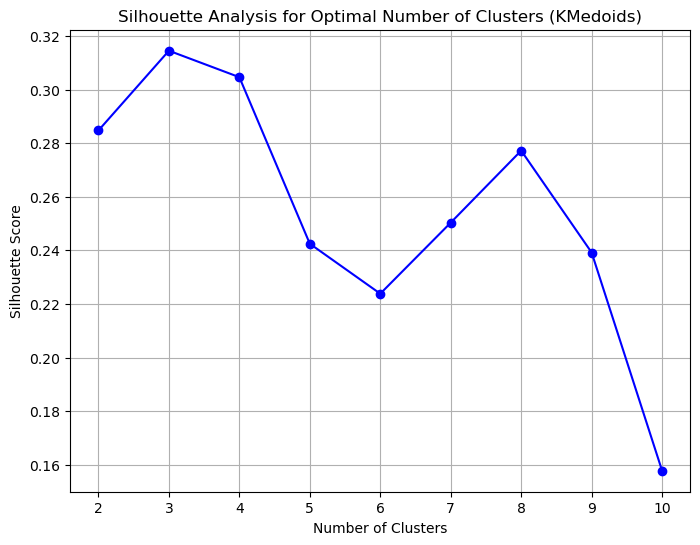

In [44]:
# For this example, let's assume you've already done the preprocessing# Select relevant features for clustering
feature_cols = ['Cognitive Events Probability', 'Accuracy']# Create a DataFrame containing only the selected features
X = df_result.dropna(subset=feature_cols)[feature_cols]# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)# Perform silhouette analysis to find the optimal number of clusters

# Perform silhouette analysis to find the optimal number of clusters
silhouette_scores = []
possible_clusters = range(2, 11)  # Try a range of cluster numbers from 2 to 10for k in possible_clusters:
for k in possible_clusters:
    kmedoids = KMedoids(n_clusters=k, random_state=0)
    cluster_labels = kmedoids.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)# Plot the silhouette scores to identify the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(possible_clusters, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters (KMedoids)')
plt.grid(True)
plt.savefig("silhouette_score.png")
plt.show()


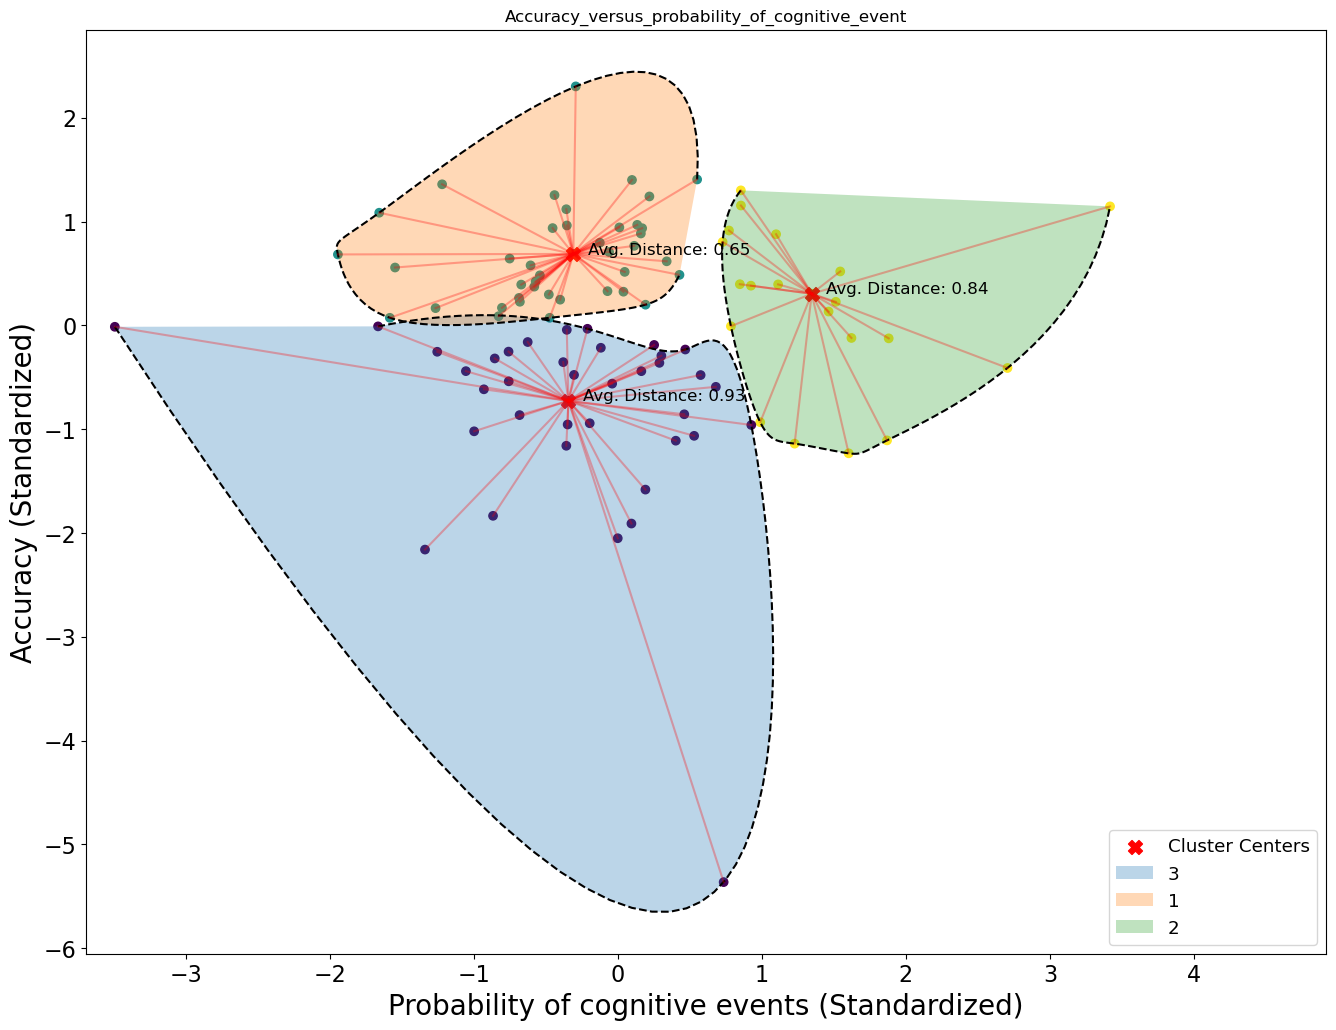

In [60]:
# Find the optimal number of clusters based on the highest silhouette score
optimal_num_clusters = possible_clusters[np.argmax(silhouette_scores)]# Fit the K-Means model with the optimal number of clusters
kmedoids = KMedoids(n_clusters=optimal_num_clusters, random_state=0)
cluster_labels = kmedoids.fit_predict(X_scaled)# Create a scatter plot of the data points colored by cluster
plt.figure(figsize=(16, 12))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis')
cluster_centers = kmedoids.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red', label='Cluster Centers')

# Define cluster labels as per your request
cluster_labels_names = ["3",
                        "1",
                        "2",
                        "4",
                        ]# Calculate average distances within each cluster
average_distances = []
for i in range(optimal_num_clusters):
    cluster_points = X_scaled[cluster_labels == i]
    distance_matrix = pairwise_distances(cluster_points, [cluster_centers[i]], metric='euclidean')
    avg_distance = np.mean(distance_matrix)
    average_distances.append(avg_distance)# Plot convex hulls around each cluster with spline interpolation and fill them with colors
for i in range(optimal_num_clusters):
    cluster_points = X_scaled[cluster_labels == i]
    hull = ConvexHull(cluster_points)    # Perform spline interpolation
    x = cluster_points[hull.vertices, 0]
    y = cluster_points[hull.vertices, 1]
    t = np.linspace(0, 1, len(x))
    t_new = np.linspace(0, 1, 100)  # Adjust the number of points for smoother interpolation
    spl_x = interp1d(t, x, kind='cubic')
    spl_y = interp1d(t, y, kind='cubic')
    x_smooth = spl_x(t_new)
    y_smooth = spl_y(t_new)    
    plt.plot(x_smooth, y_smooth, 'k--')    # Fill the convex hull with a color based on cluster label
    plt.fill(x_smooth, y_smooth, alpha=0.3, label=cluster_labels_names[i])    # Add the average distance as a text label next to the cluster center
    plt.text(cluster_centers[i, 0] + 0.1, cluster_centers[i, 1], f'Avg. Distance: {average_distances[i]:.2f}', fontsize=12)# Connect data points to their cluster centroids
for i in range(optimal_num_clusters):
    cluster_center = cluster_centers[i]
    cluster_points = X_scaled[cluster_labels == i]
    for point in cluster_points:
        plt.plot([cluster_center[0], point[0]], [cluster_center[1], point[1]], 'r-', alpha=0.3)
        plt.xlabel('Probability of cognitive events (Standardized)',fontsize=20)
plt.ylabel('Accuracy (Standardized)',fontsize=20)
plt.xlim(X_scaled[:, 0].min() - 0.2, X_scaled[:, 0].max() + 1.5)
plt.legend(fontsize=13.2, loc='lower right')  # Adjust the font size and position of the legend
plt.xticks(fontsize=16)  # Adjust the font size of the ticks on the x-axis
plt.yticks(fontsize=16)
plt.grid(False)
plt.title('Accuracy_versus_probability_of_cognitive_event')
plt.savefig("Acc_vs_cognitive_event.png")
plt.show()


In [54]:
cluster_labels

array([0, 0, 0, 1, 1, 0, 2, 2, 0, 2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 2, 1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2,
       2, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0,
       0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 1, 2,
       1, 0, 1, 0, 2, 2, 1, 1, 0, 1, 1, 2])

In [55]:
# Swap 0 to 1, 1 to 0, and keep 2 the same
cluster_labels = np.where(cluster_labels == 0, 1, np.where(cluster_labels == 1, 0, cluster_labels))

print(swapped_labels)

[1 1 1 0 0 1 2 2 1 2 0 2 1 0 1 0 1 0 1 0 0 0 0 0 1 2 0 0 1 1 0 1 0 2 0 0 0
 0 1 0 2 1 0 2 2 0 2 1 1 0 1 0 1 1 1 1 1 1 1 2 1 0 0 1 0 1 1 2 0 2 1 2 0 0
 1 2 1 2 0 0 2 1 1 0 1 0 0 2 0 1 0 1 2 2 0 0 1 0 0 2]


/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/

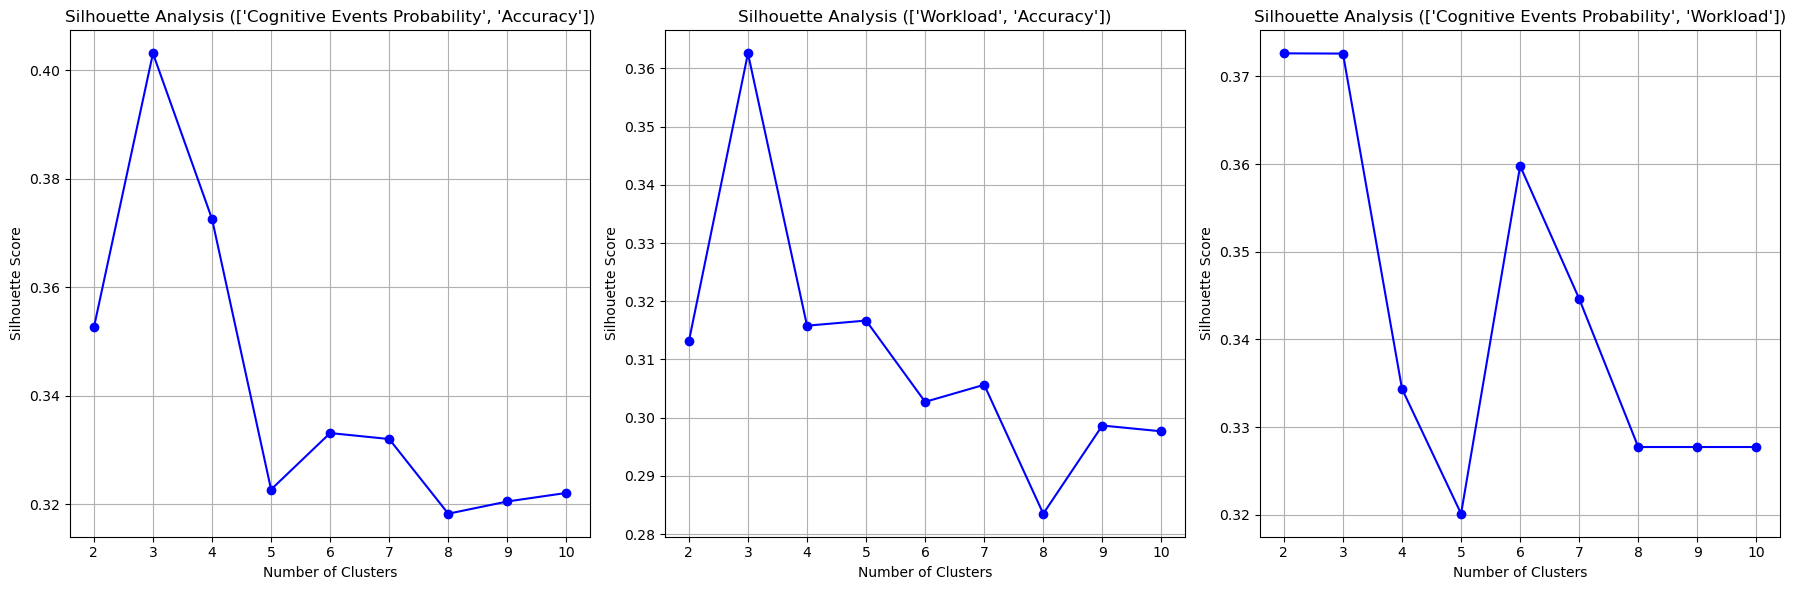

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import pandas as pd

# Assuming df_result is your DataFrame
# Define the different feature sets for each subplot
feature_sets = [
    ['Cognitive Events Probability', 'Accuracy'],
    ['Workload', 'Accuracy'],
    ['Cognitive Events Probability', 'Workload']
]

# Initialize the figure for the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature_cols in enumerate(feature_sets):
    # Prepare the data for clustering
    X = df_result.dropna(subset=feature_cols)[feature_cols]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform silhouette analysis to find the optimal number of clusters
    silhouette_scores = []
    possible_clusters = range(2, 11)  # Try a range of cluster numbers from 2 to 10
    
    for k in possible_clusters:
        kmedoids = KMedoids(n_clusters=k, random_state=0)
        cluster_labels = kmedoids.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    # Plot the silhouette scores in the corresponding subplot
    axes[i].plot(possible_clusters, silhouette_scores, marker='o', linestyle='-', color='b')
    axes[i].set_xlabel('Number of Clusters')
    axes[i].set_ylabel('Silhouette Score')
    axes[i].set_title(f'Silhouette Analysis ({feature_cols})')
    axes[i].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig("silhouette_score_3_subplots.png")
plt.show()


In [15]:
difficulty_mapping = {'Easy': 1, 'Medium': 2, 'Hard': 3}

/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/

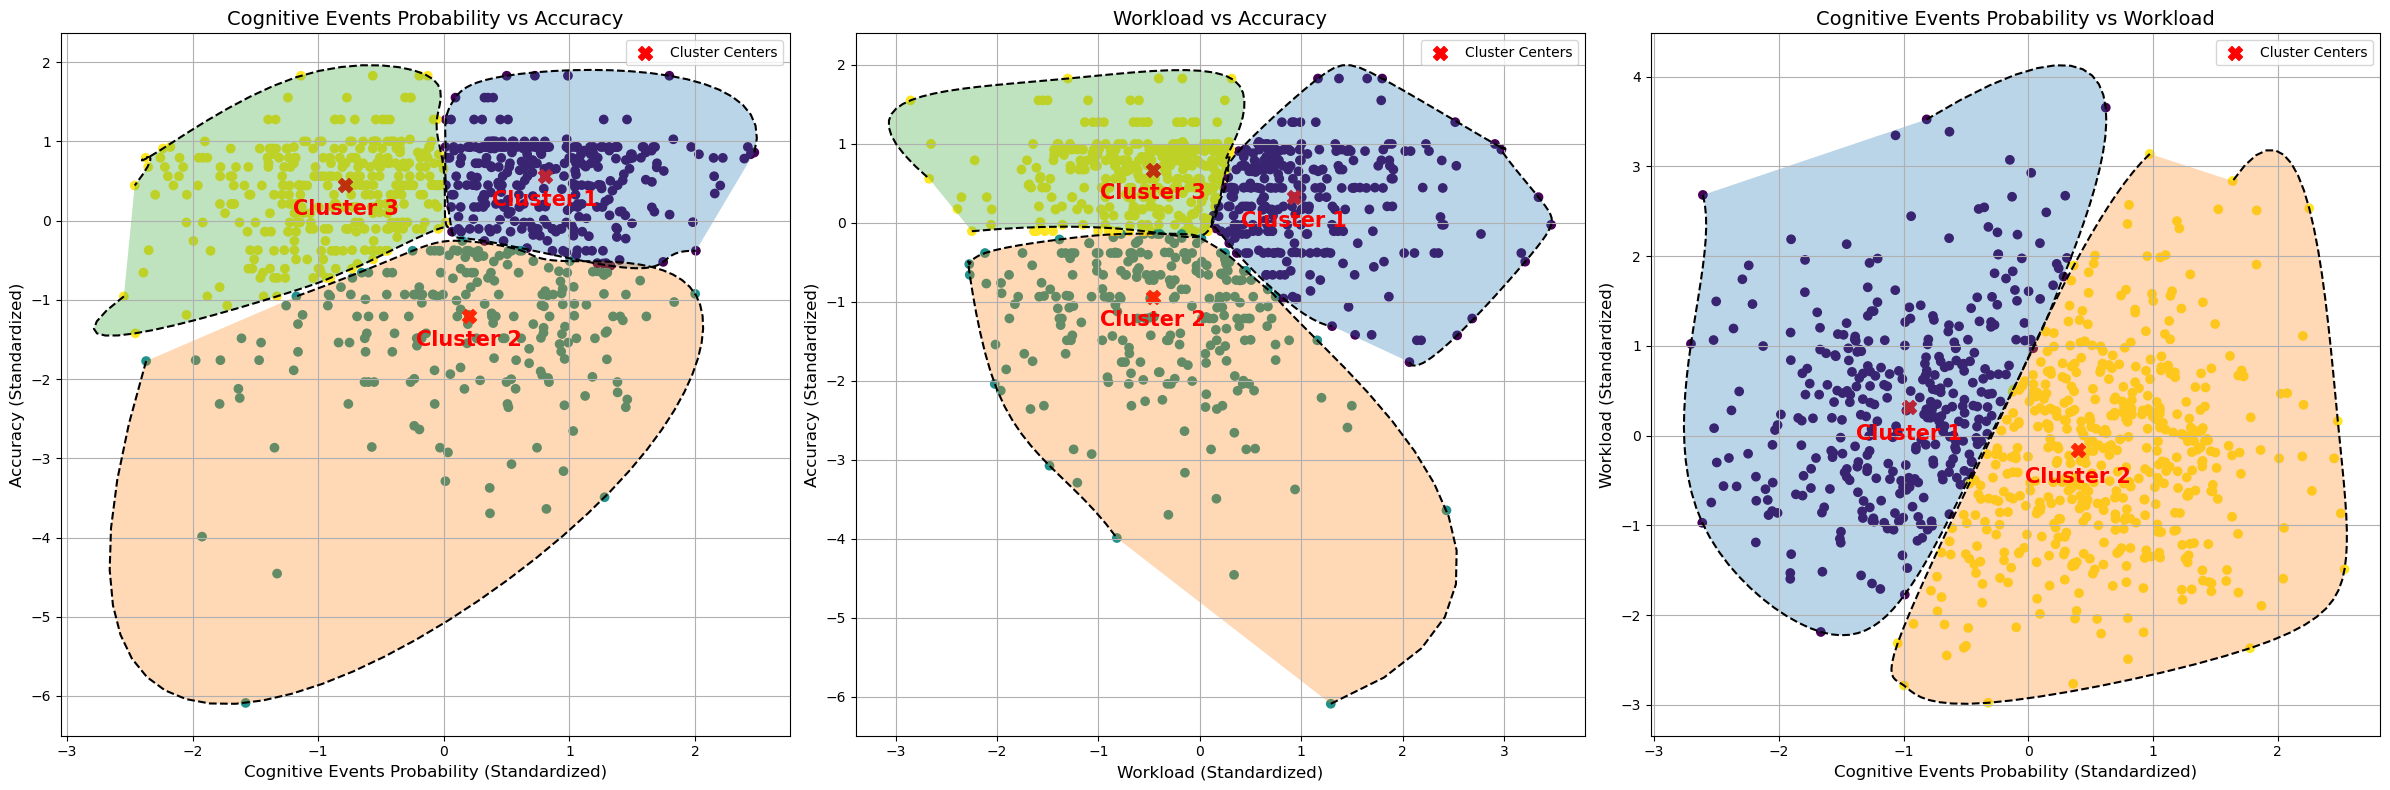

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from sklearn.metrics import pairwise_distances

# Assuming df_result is your DataFrame with relevant data

# Function to perform clustering and plot results
def plot_cluster_analysis(feature_cols, ax, title):
    X = df_result.dropna(subset=feature_cols)[feature_cols]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform silhouette analysis to find the optimal number of clusters
    silhouette_scores = []
    possible_clusters = range(2, 11)
    for k in possible_clusters:
        kmedoids = KMedoids(n_clusters=k, random_state=0)
        cluster_labels = kmedoids.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    # Find the optimal number of clusters based on the highest silhouette score
    optimal_num_clusters = possible_clusters[np.argmax(silhouette_scores)]
    
    # Fit the K-Medoids model with the optimal number of clusters
    kmedoids = KMedoids(n_clusters=optimal_num_clusters, random_state=0)
    cluster_labels = kmedoids.fit_predict(X_scaled)
    
    # Create a scatter plot of the data points colored by cluster
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis')
    cluster_centers = kmedoids.cluster_centers_
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red', label='Cluster Centers')


    # Label each cluster at the cluster center
    for i, center in enumerate(cluster_centers):
        ax.text(center[0], center[1]-0.3, f'Cluster {i+1}', fontsize=15, weight='bold', ha='center', va='center', color='red')
        
    # Plot convex hulls around each cluster with spline interpolation and fill them with colors
    for i in range(optimal_num_clusters):
        cluster_points = X_scaled[cluster_labels == i]
        if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
            hull = ConvexHull(cluster_points)
            x = cluster_points[hull.vertices, 0]
            y = cluster_points[hull.vertices, 1]
            t = np.linspace(0, 1, len(x))
            t_new = np.linspace(0, 1, 100)
            spl_x = interp1d(t, x, kind='cubic')
            spl_y = interp1d(t, y, kind='cubic')
            x_smooth = spl_x(t_new)
            y_smooth = spl_y(t_new)
            ax.plot(x_smooth, y_smooth, 'k--')
            ax.fill(x_smooth, y_smooth, alpha=0.3)
    
    # Set labels and title for the subplot
    ax.set_xlabel(f'{feature_cols[0]} (Standardized)', fontsize=12)
    ax.set_ylabel(f'{feature_cols[1]} (Standardized)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    ax.legend(loc='best')

# Define the features and titles for the subplots
subplots_info = [
    (['Cognitive Events Probability', 'Accuracy'], 'Cognitive Events Probability vs Accuracy'),
    (['Workload', 'Accuracy'], 'Workload vs Accuracy'),
    (['Cognitive Events Probability', 'Workload'], 'Cognitive Events Probability vs Workload')
]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot each cluster analysis in a subplot
for i, (feature_cols, title) in enumerate(subplots_info):
    plot_cluster_analysis(feature_cols, axes[i], title)

plt.tight_layout()
plt.savefig("cluster_analysis_3_subplots.png")
plt.show()


/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
/home/qdang1/.conda/envs/tf-2-10/lib/python3.8/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
/home/qdang1/.conda/

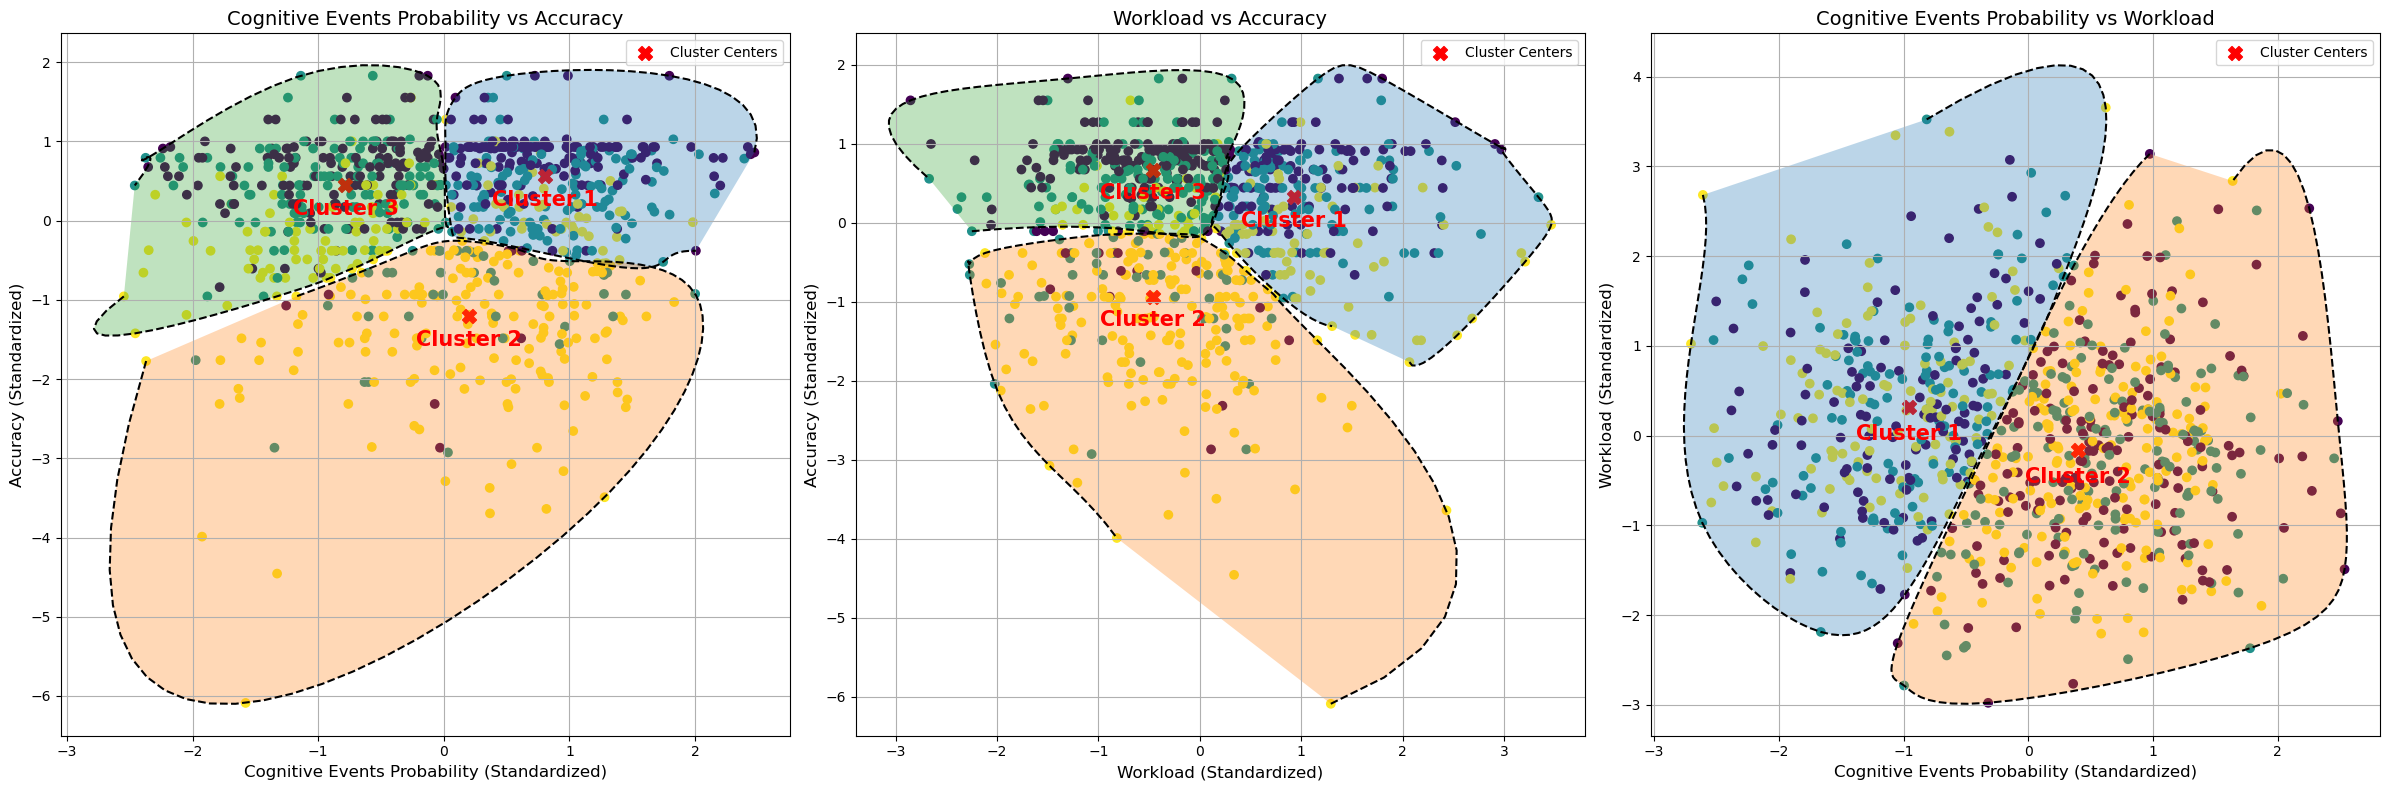

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from sklearn.metrics import pairwise_distances

# Assuming df_result is your DataFrame with relevant data

# Function to perform clustering and plot results
def plot_cluster_analysis(feature_cols, ax, title):
    X = df_result.dropna(subset=feature_cols)[feature_cols]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform silhouette analysis to find the optimal number of clusters
    silhouette_scores = []
    possible_clusters = range(2, 11)
    for k in possible_clusters:
        kmedoids = KMedoids(n_clusters=k, random_state=0)
        cluster_labels = kmedoids.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    # Find the optimal number of clusters based on the highest silhouette score
    optimal_num_clusters = possible_clusters[np.argmax(silhouette_scores)]
    
    # Fit the K-Medoids model with the optimal number of clusters
    kmedoids = KMedoids(n_clusters=optimal_num_clusters, random_state=0)
    cluster_labels = kmedoids.fit_predict(X_scaled)

    diff_encoding = df_result.dropna(subset=feature_cols)['Difficulty'].map(difficulty_mapping)
    # Create a scatter plot of the data points colored by cluster
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=diff_encoding, cmap='viridis')
    cluster_centers = kmedoids.cluster_centers_
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red', label='Cluster Centers')


    # Label each cluster at the cluster center
    for i, center in enumerate(cluster_centers):
        ax.text(center[0], center[1]-0.3, f'Cluster {i+1}', fontsize=15, weight='bold', ha='center', va='center', color='red')
        
    # Plot convex hulls around each cluster with spline interpolation and fill them with colors
    for i in range(optimal_num_clusters):
        cluster_points = X_scaled[cluster_labels == i]
        if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
            hull = ConvexHull(cluster_points)
            x = cluster_points[hull.vertices, 0]
            y = cluster_points[hull.vertices, 1]
            t = np.linspace(0, 1, len(x))
            t_new = np.linspace(0, 1, 100)
            spl_x = interp1d(t, x, kind='cubic')
            spl_y = interp1d(t, y, kind='cubic')
            x_smooth = spl_x(t_new)
            y_smooth = spl_y(t_new)
            ax.plot(x_smooth, y_smooth, 'k--')
            ax.fill(x_smooth, y_smooth, alpha=0.3)
    
    # Set labels and title for the subplot
    ax.set_xlabel(f'{feature_cols[0]} (Standardized)', fontsize=12)
    ax.set_ylabel(f'{feature_cols[1]} (Standardized)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    ax.legend(loc='best')

# Define the features and titles for the subplots
subplots_info = [
    (['Cognitive Events Probability', 'Accuracy'], 'Cognitive Events Probability vs Accuracy'),
    (['Workload', 'Accuracy'], 'Workload vs Accuracy'),
    (['Cognitive Events Probability', 'Workload'], 'Cognitive Events Probability vs Workload')
]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot each cluster analysis in a subplot
for i, (feature_cols, title) in enumerate(subplots_info):
    plot_cluster_analysis(feature_cols, axes[i], title)

plt.tight_layout()
plt.savefig("cluster_analysis_3_subplots_by_difficulty.png")
plt.show()


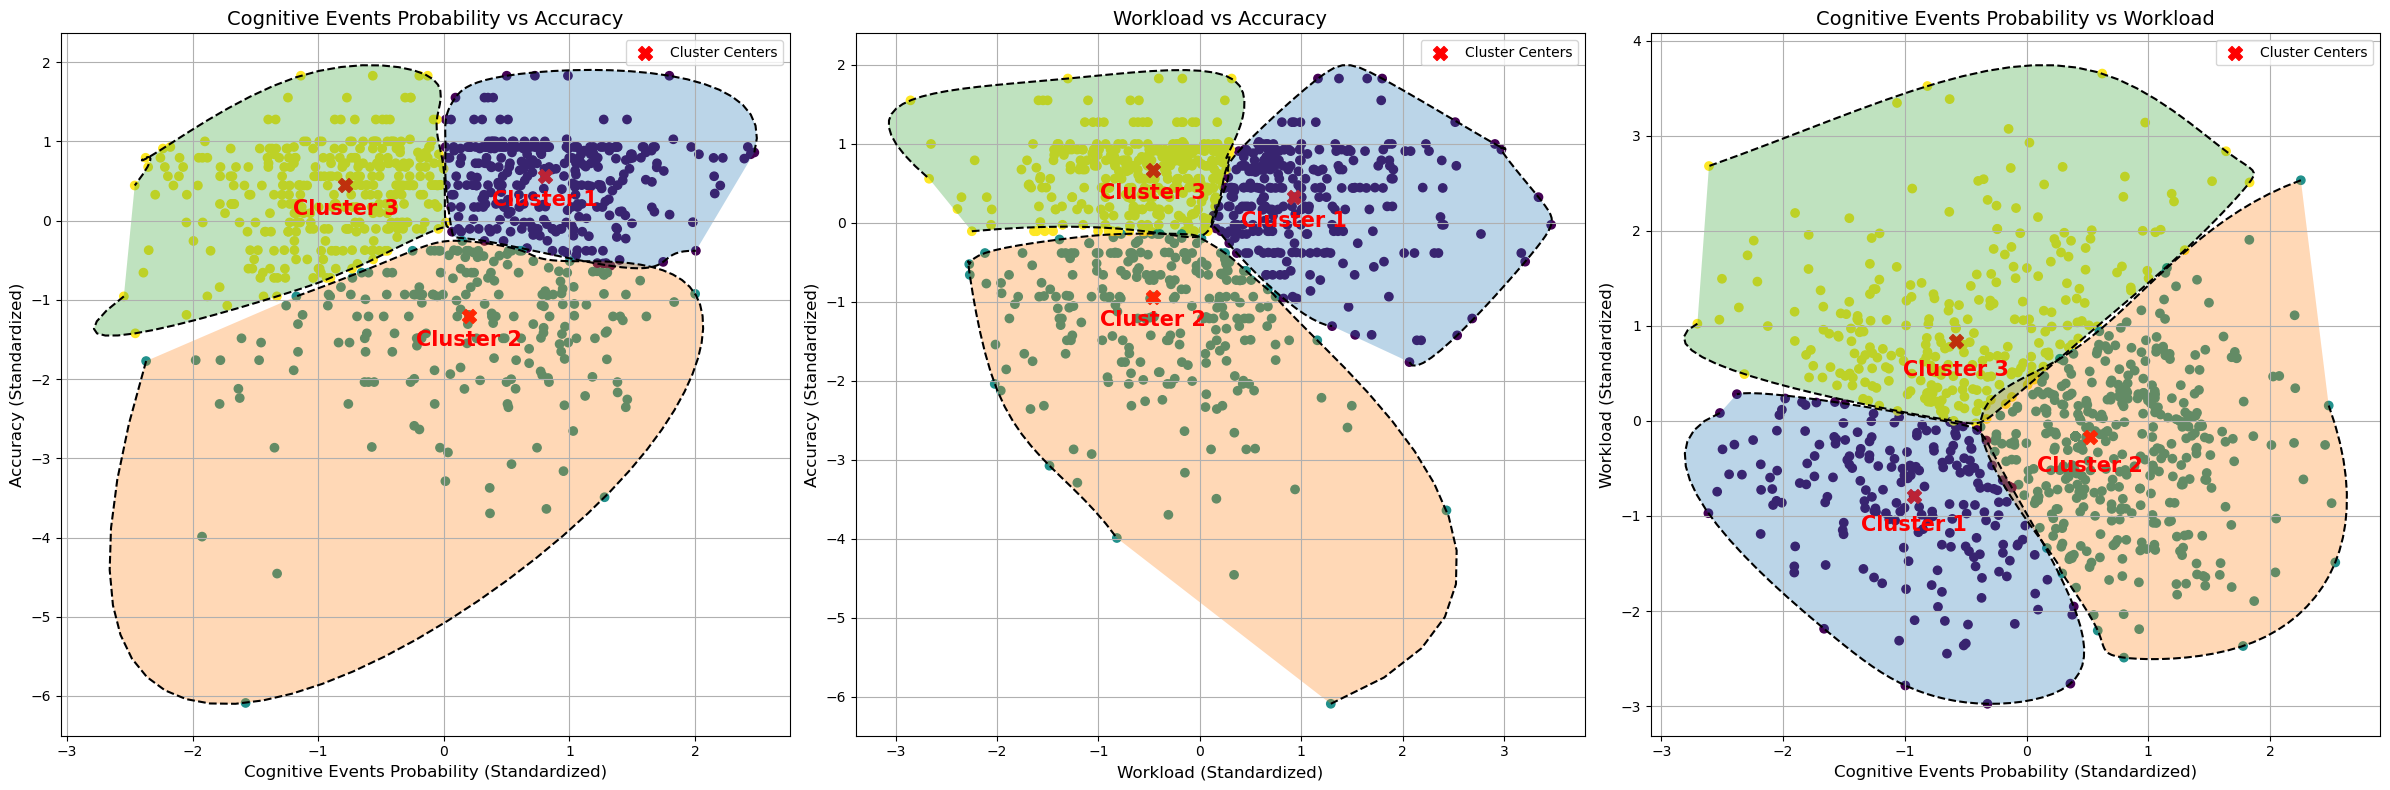

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

# Assuming df_result is your DataFrame with relevant data

# Function to perform clustering and plot results
def plot_cluster_analysis(feature_cols, ax, title):
    X = df_result.dropna(subset=feature_cols)[feature_cols]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Set the number of clusters to 3
    num_clusters = 3
    
    # Fit the K-Medoids model with 3 clusters
    kmedoids = KMedoids(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmedoids.fit_predict(X_scaled)
    
    # Create a scatter plot of the data points colored by cluster
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis')
    cluster_centers = kmedoids.cluster_centers_
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red', label='Cluster Centers')

    # Label each cluster at the cluster center
    for i, center in enumerate(cluster_centers):
        ax.text(center[0], center[1]-0.3, f'Cluster {i+1}', fontsize=15, weight='bold', ha='center', va='center', color='red')
        
    # Plot convex hulls around each cluster with spline interpolation and fill them with colors
    for i in range(num_clusters):
        cluster_points = X_scaled[cluster_labels == i]
        if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
            hull = ConvexHull(cluster_points)
            x = cluster_points[hull.vertices, 0]
            y = cluster_points[hull.vertices, 1]
            t = np.linspace(0, 1, len(x))
            t_new = np.linspace(0, 1, 100)
            spl_x = interp1d(t, x, kind='cubic')
            spl_y = interp1d(t, y, kind='cubic')
            x_smooth = spl_x(t_new)
            y_smooth = spl_y(t_new)
            ax.plot(x_smooth, y_smooth, 'k--')
            ax.fill(x_smooth, y_smooth, alpha=0.3)
    
    # Set labels and title for the subplot
    ax.set_xlabel(f'{feature_cols[0]} (Standardized)', fontsize=12)
    ax.set_ylabel(f'{feature_cols[1]} (Standardized)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    ax.legend(loc='best')

# Define the features and titles for the subplots
subplots_info = [
    (['Cognitive Events Probability', 'Accuracy'], 'Cognitive Events Probability vs Accuracy'),
    (['Workload', 'Accuracy'], 'Workload vs Accuracy'),
    (['Cognitive Events Probability', 'Workload'], 'Cognitive Events Probability vs Workload')
]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot each cluster analysis in a subplot
for i, (feature_cols, title) in enumerate(subplots_info):
    plot_cluster_analysis(feature_cols, axes[i], title)

plt.tight_layout()
plt.savefig("cluster_analysis_subplots_fixed_3_clusters.png")
plt.show()


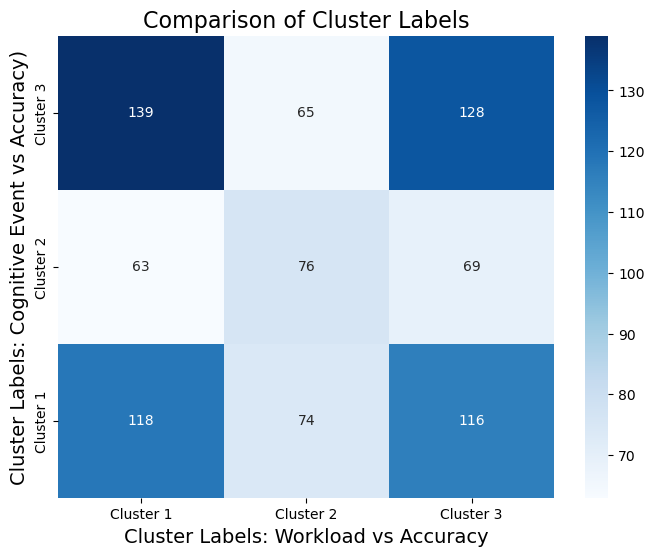

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import confusion_matrix

# Assuming df_result is your DataFrame with relevant data

# Define the feature sets
feature_sets = [
    ['Cognitive Events Probability', 'Accuracy'],
    ['Workload', 'Accuracy'],
]

# Set the number of clusters to 3
num_clusters = 3

# Function to perform clustering and return cluster labels
def get_cluster_labels(feature_cols):
    X = df_result.dropna()[feature_cols]
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    
    # Fit the K-Medoids model with 3 clusters
    kmedoids = KMedoids(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmedoids.fit_predict(X_scaled)
    
    return cluster_labels

# Generate cluster labels for both feature sets
cluster_labels_1 = get_cluster_labels(feature_sets[0])
cluster_labels_2 = get_cluster_labels(feature_sets[1])


# Compute a confusion matrix as a measure of comparison
conf_matrix = confusion_matrix(cluster_labels_1, cluster_labels_2[::-1])

# Create a heatmap of the confusion matrix with y-axis reversed
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix[::-1], annot=True, cmap='Blues', fmt='d',
            xticklabels=[f'Cluster {i+1}' for i in range(num_clusters)],
            yticklabels=[f'Cluster {i+1}' for i in range(num_clusters)][::-1])  # Reverse y-axis labels
plt.xlabel('Cluster Labels: Workload vs Accuracy', fontsize=14)
plt.ylabel('Cluster Labels: Cognitive Event vs Accuracy)', fontsize=14)
plt.title('Comparison of Cluster Labels', fontsize=16)
plt.savefig('heatmap_between_eye_and_ecg.png')
plt.show()


In [72]:
cluster_label_df = pd.DataFrame()
cluster_label_df['Subject_id'] = df_result.dropna()['userid']
cluster_label_df['cluster_label_cognitive'] = get_cluster_labels(feature_sets[0])
cluster_label_df['cluster_label_workload'] = get_cluster_labels(feature_sets[1])
cluster_label_df


Subject_id  cluster_label_cognitive  cluster_label_workload
0         AXSW                        2                       2
1         AXSW                        0                       0
2         AXSW                        1                       2
3         AXSW                        2                       2
4         AXSW                        1                       1
..         ...                      ...                     ...
867       ZYXW                        2                       2
868       ZYXW                        2                       2
869       ZYXW                        0                       2
870       ZYXW                        0                       2
871       ZYXW                        0                       2

[848 rows x 3 columns]

In [61]:
# cluster_label_df = pd.DataFrame()
# cluster_label_df['Subject_id'] = df_result.dropna(subset=feature_cols)['userid']
# cluster_label_df['cluster_label'] = cluster_labels + 1
# cluster_label_df['cluster_label'] = cluster_label_df['cluster_label'].replace({1: 2, 2: 1}).replace({2: 3, 3: 2})
# cluster_label_df

Subject_id  cluster_label
0        AXSW              3
1        BHGY              3
2        BVCX              3
3        CVBN              1
4        DFGH              1
..        ...            ...
95       ZXCJ              1
96       ZXCV              3
97       ZXNM              1
98       ZXWE              1
99       ZYXW              2

[100 rows x 2 columns]

In [62]:
# cluster_label_df.to_csv("cluster_24_08_17.csv",index=False)

In [74]:
cluster_label_df[cluster_label_df['cluster_label_cognitive'] == cluster_label_df['cluster_label_workload']]

Subject_id  cluster_label_cognitive  cluster_label_workload
0         AXSW                        2                       2
1         AXSW                        0                       0
3         AXSW                        2                       2
4         AXSW                        1                       1
7         AXSW                        1                       1
..         ...                      ...                     ...
859       ZXWE                        2                       2
862       ZXWE                        0                       0
864       ZYXW                        1                       1
867       ZYXW                        2                       2
868       ZYXW                        2                       2

[470 rows x 3 columns]

# 3D Clustering

In [1]:
#%matplotlib inline
 

In [8]:
df_result = pd.read_pickle("df_result_prob.pkl")
df_result

userid       Task_type Difficulty  ecg_prob  eye_prob  Accuracy
0     AXSW     enumeration       Easy  0.424950  0.225486  0.703558
1     AXSW     enumeration       Hard  0.448148  0.276822  0.169886
2     AXSW     enumeration     Medium  0.388859  0.241656 -0.363786
3     AXSW  task_switching       Easy  0.418245  0.221525  0.319643
4     AXSW  task_switching       Hard  0.374787  0.208495 -1.595959
..     ...             ...        ...       ...       ...       ...
986   ZXNM  task_switching       Easy       NaN  0.199773  0.883055
987   ZXNM  working_memory       Easy       NaN  0.280562  0.902001
988   ZXNM  working_memory       Hard       NaN  0.304837  0.051529
989   ZXNM  working_memory     Medium       NaN  0.328384  0.813311
990   QPMN  task_switching       Hard       NaN       NaN -8.131543

[991 rows x 6 columns]

In [9]:
df_result = df_result.rename({'eye_prob' : 'Cognitive Events Probability',
                  'ecg_prob' : 'Workload'}, axis=1)
df_result

userid       Task_type Difficulty  Workload  Cognitive Events Probability  \
0     AXSW     enumeration       Easy  0.424950                      0.225486   
1     AXSW     enumeration       Hard  0.448148                      0.276822   
2     AXSW     enumeration     Medium  0.388859                      0.241656   
3     AXSW  task_switching       Easy  0.418245                      0.221525   
4     AXSW  task_switching       Hard  0.374787                      0.208495   
..     ...             ...        ...       ...                           ...   
986   ZXNM  task_switching       Easy       NaN                      0.199773   
987   ZXNM  working_memory       Easy       NaN                      0.280562   
988   ZXNM  working_memory       Hard       NaN                      0.304837   
989   ZXNM  working_memory     Medium       NaN                      0.328384   
990   QPMN  task_switching       Hard       NaN                           NaN   

     Accuracy  
0    0.703558  
1    0.169886  
2   -0.363786  
3    0.319643  
4   -1.595959  
..        ...  
986  0.883055  
987  0.902001  
988  0.051529  
989  0.813311  
990 -8.131543  

[991 rows x 6 columns]

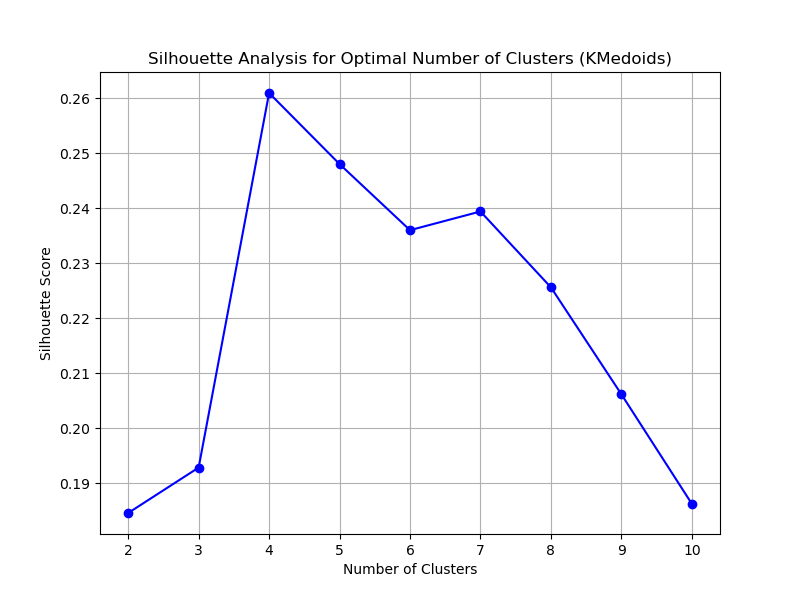

In [10]:
# For this example, let's assume you've already done the preprocessing# Select relevant features for clustering
feature_cols = ['Workload', 'Cognitive Events Probability', 'Accuracy']# Create a DataFrame containing only the selected features
X = df_result.dropna(subset=feature_cols)[feature_cols]# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)# Perform silhouette analysis to find the optimal number of clusters

# Perform silhouette analysis to find the optimal number of clusters
silhouette_scores = []
possible_clusters = range(2, 11)  # Try a range of cluster numbers from 2 to 10for k in possible_clusters:
for k in possible_clusters:
    kmedoids = KMedoids(n_clusters=k, random_state=0)
    cluster_labels = kmedoids.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)# Plot the silhouette scores to identify the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(possible_clusters, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters (KMedoids)')
plt.grid(True)
plt.savefig("silhouette_score.png")
plt.show()


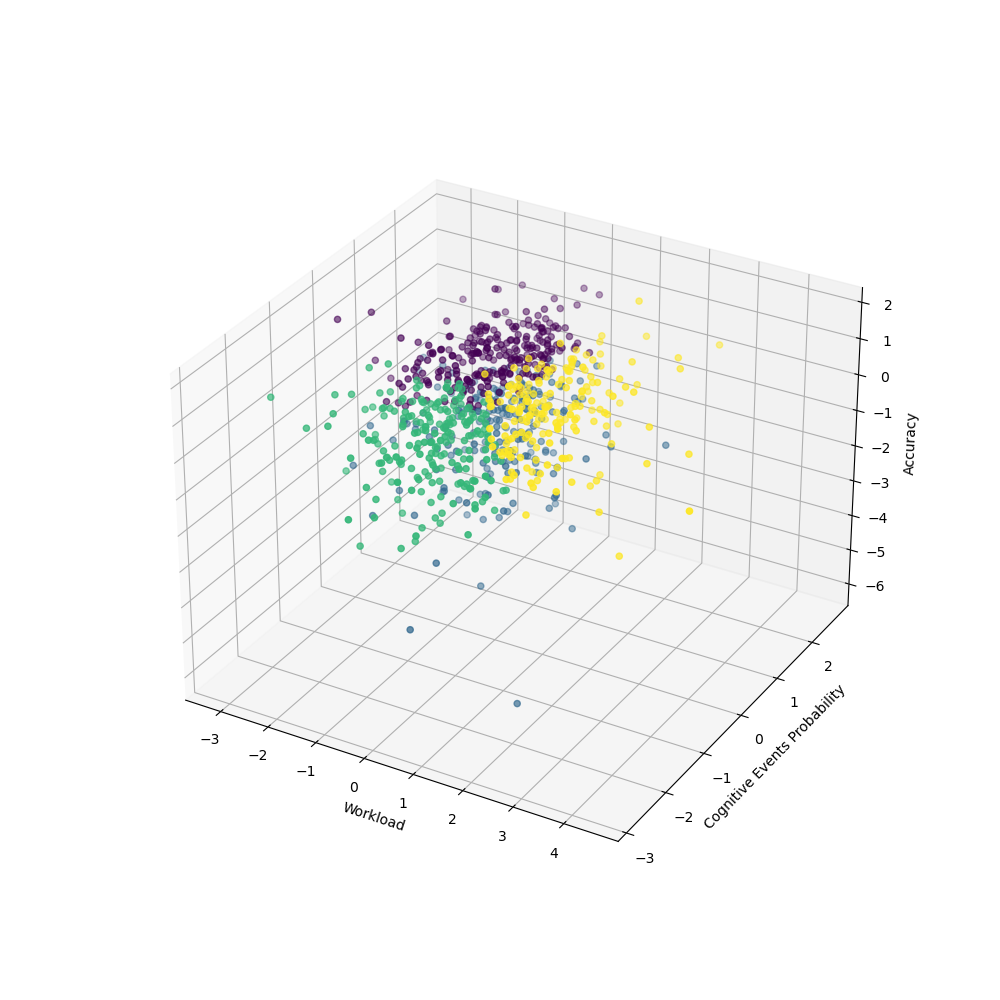

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode for JupyterLab or newer Jupyter versions
optimal_num_clusters = possible_clusters[np.argmax(silhouette_scores)]# Fit the K-Means model with the optimal number of clusters
kmedoids = KMedoids(n_clusters=optimal_num_clusters, random_state=0)
cluster_labels = kmedoids.fit_predict(X_scaled)# Create a scatter plot of the data points colored by cluster

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=cluster_labels, marker='o')

# Set labels
ax.set_xlabel('Workload')
ax.set_ylabel('Cognitive Events Probability')
ax.set_zlabel('Accuracy')

# Show plot
plt.show()


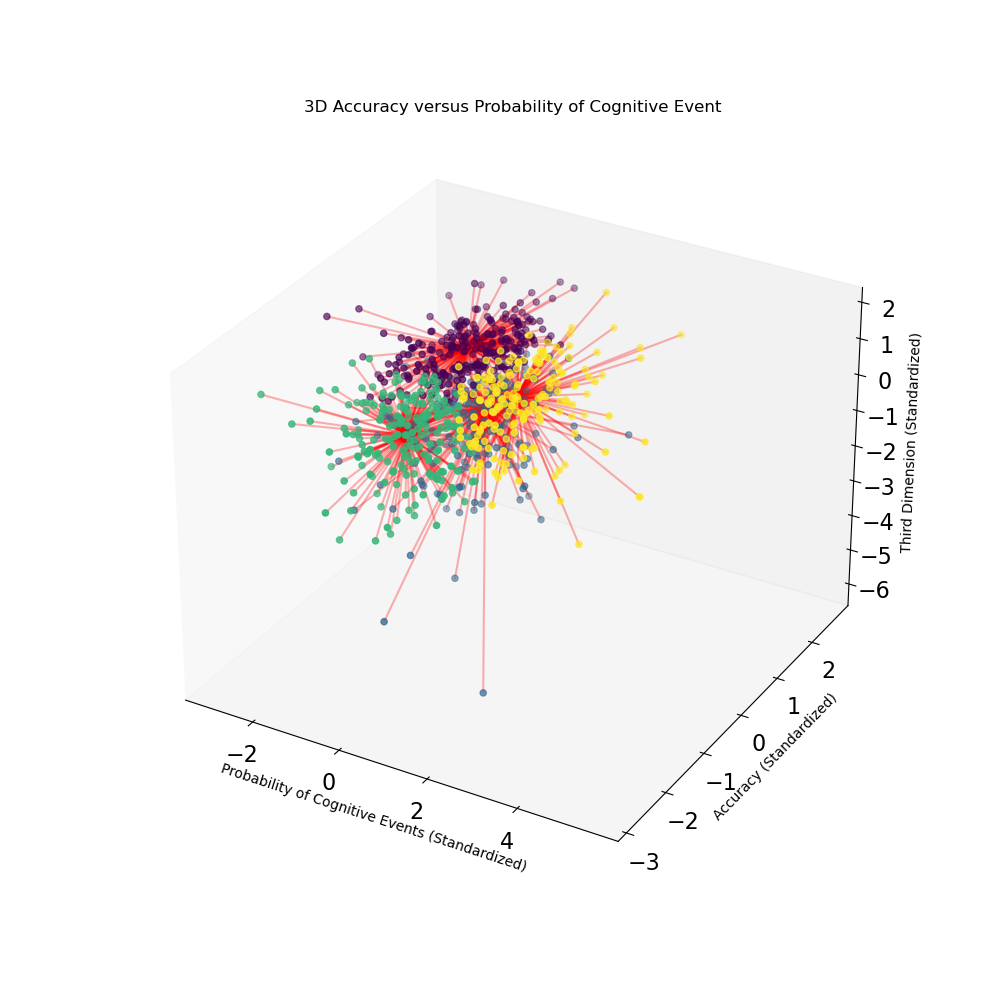

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from sklearn.metrics import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D

# Assuming possible_clusters and silhouette_scores are defined
optimal_num_clusters = possible_clusters[np.argmax(silhouette_scores)]

# Fit the K-Medoids model with the optimal number of clusters
kmedoids = KMedoids(n_clusters=optimal_num_clusters, random_state=0)
cluster_labels = kmedoids.fit_predict(X_scaled)

# Create a 3D scatter plot of the data points colored by cluster
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=cluster_labels, cmap='viridis')

# Plot the cluster centers
cluster_centers = kmedoids.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], marker='X', s=100, c='red', label='Cluster Centers')

# Define cluster labels
cluster_labels_names = ["3", "1", "2", "4"]

# Calculate average distances within each cluster
average_distances = []
for i in range(optimal_num_clusters):
    cluster_points = X_scaled[cluster_labels == i]
    distance_matrix = pairwise_distances(cluster_points, [cluster_centers[i]], metric='euclidean')
    avg_distance = np.mean(distance_matrix)
    average_distances.append(avg_distance)

# # Plot convex hulls around each cluster with spline interpolation and fill them with colors
# for i in range(optimal_num_clusters):
#     cluster_points = X_scaled[cluster_labels == i]
#     hull = ConvexHull(cluster_points)
    
#     # Perform spline interpolation
#     x = cluster_points[hull.vertices, 0]
#     y = cluster_points[hull.vertices, 1]
#     z = cluster_points[hull.vertices, 2]
#     t = np.linspace(0, 1, len(x))
#     t_new = np.linspace(0, 1, 100)  # Adjust the number of points for smoother interpolation
#     spl_x = interp1d(t, x, kind='cubic')
#     spl_y = interp1d(t, y, kind='cubic')
#     spl_z = interp1d(t, z, kind='cubic')
#     x_smooth = spl_x(t_new)
#     y_smooth = spl_y(t_new)
#     z_smooth = spl_z(t_new)
    
#     # Plot the smoothed convex hulls
#     ax.plot(x_smooth, y_smooth, z_smooth, 'k--')
    
#     # Fill the convex hull with a color based on cluster label
#     ax.plot_trisurf(x_smooth, y_smooth, z_smooth, alpha=0.3, label=cluster_labels_names[i])
    
#     # Add the average distance as a text label next to the cluster center
#     ax.text(cluster_centers[i, 0] + 0.1, cluster_centers[i, 1], cluster_centers[i, 2], f'Avg. Distance: {average_distances[i]:.2f}', fontsize=12)

# Connect data points to their cluster centroids
for i in range(optimal_num_clusters):
    cluster_center = cluster_centers[i]
    cluster_points = X_scaled[cluster_labels == i]
    for point in cluster_points:
        ax.plot([cluster_center[0], point[0]], [cluster_center[1], point[1]], [cluster_center[2], point[2]], 'r-', alpha=0.3)

# Set labels
ax.set_xlabel('Probability of Cognitive Events (Standardized)')
ax.set_ylabel('Accuracy (Standardized)')
ax.set_zlabel('Third Dimension (Standardized)')

# Set limits and grid
ax.set_xlim(X_scaled[:, 0].min() - 0.2, X_scaled[:, 0].max() + 1.5)
#ax.legend(fontsize=13.2, loc='lower right')  # Adjust the font size and position of the legend
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(False)

# Set title
ax.set_title('3D Accuracy versus Probability of Cognitive Event')

# Save and show plot
#plt.savefig("3D_Acc_vs_Cognitive_Event.png")
plt.show()
